In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research;D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research\slim

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# append object_detection dir
sys.path.append("research/object_detection/..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

OD_PATH = 'research/object_detection/'

In [5]:
# FUNCTIONS
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [6]:
# Additional Functions
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]


def one_hot_encode_to_char_list(arr, threshold=0.5, get_max=True):
    result = []
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((i, arr[i]))
    _max = []
    high = 0
    result = sorted(result, key=lambda x: x[1], reverse=True)
    if get_max:
        return result[-1]
    return result

In [7]:
# VARIABLES
MODEL_NAME = 'trained_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "training/data/object-detection.pbtxt"

In [8]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


In [9]:
# Load label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [10]:
# DETECTION
PATH_TO_TEST_IMAGES_DIR = OD_PATH + "training/test_images/*"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print("Test Image paths: ")
for i in TEST_IMAGE_PATHS:
    print(i)
IMAGE_SIZE = (320, 320)

Test Image paths: 
research/object_detection/training/test_images\exp0010.png
research/object_detection/training/test_images\exp0011.png
research/object_detection/training/test_images\exp0012.png
research/object_detection/training/test_images\exp0013.png
research/object_detection/training/test_images\exp0014.png
research/object_detection/training/test_images\exp0015.png
research/object_detection/training/test_images\exp0016.png
research/object_detection/training/test_images\exp0017.png
research/object_detection/training/test_images\exp0018.png
research/object_detection/training/test_images\exp0019.png
research/object_detection/training/test_images\exp0020.png
research/object_detection/training/test_images\exp0021.png
research/object_detection/training/test_images\exp0022.png
research/object_detection/training/test_images\exp0023.png
research/object_detection/training/test_images\exp0024.png
research/object_detection/training/test_images\exp0025.png
research/object_detection/training/te

In [13]:
# Load cnn model and labels
models_path = "../trained_models/"
#cnn = load_model(models_path+"hasyv2model31.h5")
cnn = load_model(models_path+"hasyv2model51.h5")
#ann = load_model(models_path+"ann1.h5")
symbols = pd.read_csv("../processed_data/symbols.csv").drop(["Unnamed: 0"], axis=1)
symbols.head()

,latex,old_symbol,new_id
0,A,31,0
1,B,32,1
2,C,33,2
3,D,34,3
4,E,35,4


#### Note: Theres no data for `=` symbol in HASYv2 dataset. Therefore the predictions for `=` are all incorrect.

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0010.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45354316  xmin:  0.8572814  ymax:  0.568138  xmax  0.9327537
left:  274.3300437927246  right:  298.4811782836914  top:  145.13381004333496  bottom  181.80416107177734
Top left point: ( 274 ,  145 ) and Bottom right point: ( 298 ,  181 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.09 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.86 %


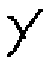

***************
Box: 
ymin:  0.49686438  xmin:  0.62040085  ymax:  0.5685543  xmax  0.6991244
left:  198.52827072143555  right:  223.71980667114258  top:  158.99660110473633  bottom  181.93737030029297
Top left point: ( 198 ,  158 ) and Bottom right point: ( 223 ,  181 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 70 , Latex: \mu , Confidence Score: 81.17 %
Symbol_id: 7 , Latex: H , Confidence Score: 8.19 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.72 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.68 %
Symbol_id: 12 , Latex: M , Confidence Score: 1.53 %


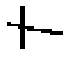

***************
Box: 
ymin:  0.451068  xmin:  0.04122157  ymax:  0.5576342  xmax  0.13480107
left:  13.190902471542358  right:  43.13634395599365  top:  144.34176445007324  bottom  178.44293594360352
Top left point: ( 13 ,  144 ) and Bottom right point: ( 43 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 31.5 %
Symbol_id: 25 , Latex: Z , Confidence Score: 23.73 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 17.24 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 8.65 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.43 %
Symbol_id: 79 , Latex: > , Confidence Score: 3.48 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 3.39 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.48 %


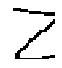

***************
Box: 
ymin:  0.46068832  xmin:  0.4106247  ymax:  0.5797235  xmax  0.50516254
left:  131.3999080657959  right:  161.6520118713379  top:  147.42026329040527  bottom  185.51151275634766
Top left point: ( 131 ,  147 ) and Bottom right point: ( 161 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.24 %


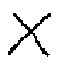

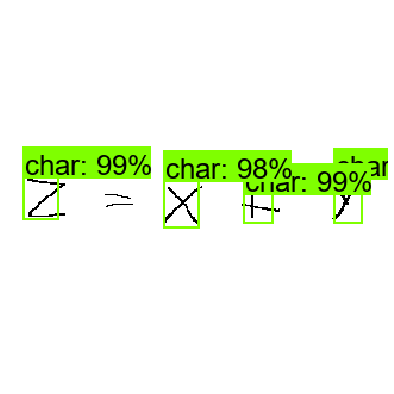

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0011.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4868632  xmin:  0.85219  ymax:  0.5942997  xmax  0.9277878
left:  272.7008056640625  right:  296.89208984375  top:  155.79622268676758  bottom  190.17589569091797
Top left point: ( 272 ,  155 ) and Bottom right point: ( 296 ,  190 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 46.06 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 14.5 %
Symbol_id: 59 , Latex: x , Confidence Score: 9.74 %
Symbol_id: 23 , Latex: X , Confidence Score: 9.14 %
Symbol_id: 60 , Latex: y , Confidence Score: 7.46 %
Symbol_id: 24 , Latex: Y , Confidence Score: 5.86 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.86 %


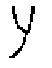

***************
Box: 
ymin:  0.49381492  xmin:  0.64456385  ymax:  0.5824494  xmax  0.71821564
left:  206.26043319702148  right:  229.82900619506836  top:  158.02077293395996  bottom  186.3838005065918
Top left point: ( 206 ,  158 ) and Bottom right point: ( 229 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 53.54 %
Symbol_id: 89 , Latex: \# , Confidence Score: 14.34 %
Symbol_id: 49 , Latex: m , Confidence Score: 4.89 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.79 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 4.37 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 3.27 %
Symbol_id: 53 , Latex: q , Confidence Score: 2.24 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.89 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.48 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.05 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.01 %


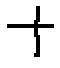

***************
Box: 
ymin:  0.46041393  xmin:  0.41168156  ymax:  0.5799028  xmax  0.50666755
left:  131.73810005187988  right:  162.13361740112305  top:  147.33245849609375  bottom  185.56890487670898
Top left point: ( 131 ,  147 ) and Bottom right point: ( 162 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.22 %


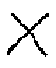

***************
Box: 
ymin:  0.45082346  xmin:  0.041032087  ymax:  0.5583327  xmax  0.13522744
left:  13.130267858505249  right:  43.27278137207031  top:  144.26350593566895  bottom  178.6664581298828
Top left point: ( 13 ,  144 ) and Bottom right point: ( 43 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 30.66 %
Symbol_id: 25 , Latex: Z , Confidence Score: 17.06 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 16.48 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 11.95 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 6.81 %
Symbol_id: 79 , Latex: > , Confidence Score: 6.34 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.65 %


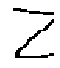

***************
Box: 
ymin:  0.5030067  xmin:  0.25158426  ymax:  0.5519426  xmax  0.3292648
left:  80.5069637298584  right:  105.36473274230957  top:  160.96214294433594  bottom  176.6216278076172
Top left point: ( 80 ,  160 ) and Bottom right point: ( 105 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 74.16 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 14.43 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.47 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.17 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.57 %


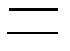

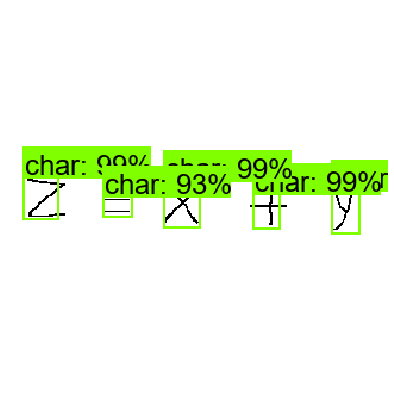

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0012.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4840625  xmin:  0.8553295  ymax:  0.59307605  xmax  0.92117137
left:  273.7054443359375  right:  294.7748374938965  top:  154.89999771118164  bottom  189.7843360900879
Top left point: ( 273 ,  154 ) and Bottom right point: ( 294 ,  189 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 79.31 %
Symbol_id: 59 , Latex: x , Confidence Score: 4.58 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.45 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.33 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.73 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.28 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.03 %


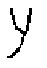

***************
Box: 
ymin:  0.4993097  xmin:  0.034913633  ymax:  0.5714435  xmax  0.12827992
left:  11.172362565994263  right:  41.04957580566406  top:  159.77910041809082  bottom  182.86191940307617
Top left point: ( 11 ,  159 ) and Bottom right point: ( 41 ,  182 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 23 , Latex: X , Confidence Score: 24.37 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 19.88 %
Symbol_id: 59 , Latex: x , Confidence Score: 16.99 %
Symbol_id: 92 , Latex: \times , Confidence Score: 10.66 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 9.16 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.39 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.69 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.85 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.06 %


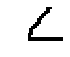

***************
Box: 
ymin:  0.49932924  xmin:  0.6362959  ymax:  0.580743  xmax  0.7137748
left:  203.61469268798828  right:  228.4079360961914  top:  159.78535652160645  bottom  185.83776473999023
Top left point: ( 203 ,  159 ) and Bottom right point: ( 228 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 41.83 %
Symbol_id: 89 , Latex: \# , Confidence Score: 21.78 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 10.55 %
Symbol_id: 49 , Latex: m , Confidence Score: 5.81 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.21 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 2.41 %
Symbol_id: 53 , Latex: q , Confidence Score: 2.29 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.95 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.46 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 1.07 %


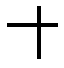

***************
Box: 
ymin:  0.49389836  xmin:  0.41921517  ymax:  0.59926534  xmax  0.5163921
left:  134.1488552093506  right:  165.24547576904297  top:  158.04747581481934  bottom  191.76490783691406
Top left point: ( 134 ,  158 ) and Bottom right point: ( 165 ,  191 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 89.58 %
Symbol_id: 90 , Latex: \% , Confidence Score: 6.8 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.59 %


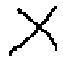

***************
Box: 
ymin:  0.50544655  xmin:  0.24833623  ymax:  0.55577326  xmax  0.32606575
left:  79.46759223937988  right:  104.34103965759277  top:  161.7428970336914  bottom  177.84744262695312
Top left point: ( 79 ,  161 ) and Bottom right point: ( 104 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 75.56 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 10.32 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.33 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 2.18 %
Symbol_id: 9 , Latex: J , Confidence Score: 2.07 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.14 %
Symbol_id: 45 , Latex: i , Confidence Score: 1.03 %


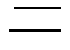

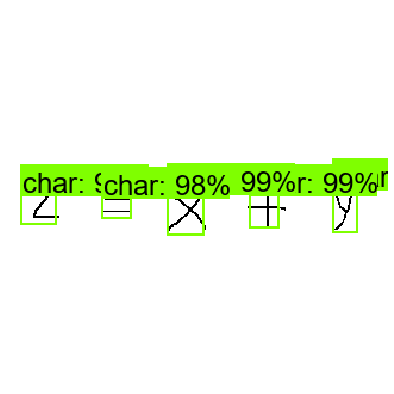

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0013.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.48841873  xmin:  0.8348692  ymax:  0.5937218  xmax  0.91877884
left:  267.158145904541  right:  294.00922775268555  top:  156.29399299621582  bottom  189.9909782409668
Top left point: ( 267 ,  156 ) and Bottom right point: ( 294 ,  189 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 27.75 %
Symbol_id: 88 , Latex: \& , Confidence Score: 22.47 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.9 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 9.09 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 8.76 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.74 %
Symbol_id: 49 , Latex: m , Confidence Score: 1.13 %


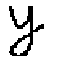

***************
Box: 
ymin:  0.49598417  xmin:  0.03926328  ymax:  0.57623893  xmax  0.14435191
left:  12.564249038696289  right:  46.192612648010254  top:  158.71493339538574  bottom  184.39645767211914
Top left point: ( 12 ,  158 ) and Bottom right point: ( 46 ,  184 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 35.0 %
Symbol_id: 90 , Latex: \% , Confidence Score: 31.02 %
Symbol_id: 25 , Latex: Z , Confidence Score: 25.69 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 5.85 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.38 %


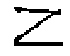

***************
Box: 
ymin:  0.5068421  xmin:  0.22598648  ymax:  0.55520874  xmax  0.31061077
left:  72.315673828125  right:  99.39544677734375  top:  162.1894645690918  bottom  177.66679763793945
Top left point: ( 72 ,  162 ) and Bottom right point: ( 99 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 43.65 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 30.22 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.58 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 3.04 %
Symbol_id: 78 , Latex: < , Confidence Score: 2.61 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.77 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.54 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 1.45 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.42 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.38 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.31 %


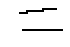

***************
Box: 
ymin:  0.46333265  xmin:  0.42038575  ymax:  0.58337396  xmax  0.5128048
left:  134.52343940734863  right:  164.09753799438477  top:  148.26644897460938  bottom  186.67966842651367
Top left point: ( 134 ,  148 ) and Bottom right point: ( 164 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.34 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


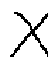

***************
Box: 
ymin:  0.49847433  xmin:  0.63836503  ymax:  0.5788991  xmax  0.71371144
left:  204.2768096923828  right:  228.3876609802246  top:  159.51178550720215  bottom  185.24770736694336
Top left point: ( 204 ,  159 ) and Bottom right point: ( 228 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 20.95 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 16.67 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 12.05 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 10.72 %
Symbol_id: 89 , Latex: \# , Confidence Score: 10.11 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 4.25 %
Symbol_id: 53 , Latex: q , Confidence Score: 2.93 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 2.68 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.56 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 2.35 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.34 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.85 %
Symbol_id: 49 , Latex: m , Confidence Score:

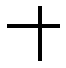

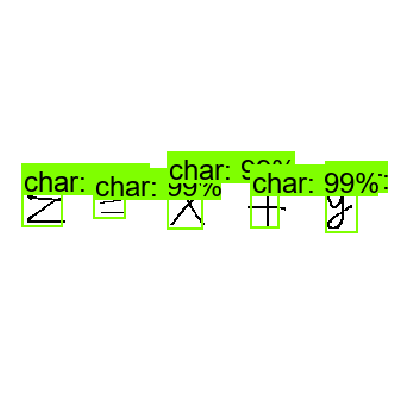

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0014.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.48498937  xmin:  0.8042011  ymax:  0.5917139  xmax  0.89826626
left:  257.3443603515625  right:  287.4452018737793  top:  155.19659996032715  bottom  189.34844970703125
Top left point: ( 257 ,  155 ) and Bottom right point: ( 287 ,  189 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 33.6 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 25.78 %
Symbol_id: 92 , Latex: \times , Confidence Score: 23.27 %
Symbol_id: 59 , Latex: x , Confidence Score: 8.62 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.57 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.58 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.01 %


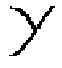

***************
Box: 
ymin:  0.46291876  xmin:  0.420893  ymax:  0.5833379  xmax  0.51428187
left:  134.68576431274414  right:  164.57019805908203  top:  148.13400268554688  bottom  186.66812896728516
Top left point: ( 134 ,  148 ) and Bottom right point: ( 164 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.14 %


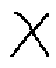

***************
Box: 
ymin:  0.5090687  xmin:  0.24742804  ymax:  0.5612414  xmax  0.31871596
left:  79.17697429656982  right:  101.98910713195801  top:  162.90199279785156  bottom  179.5972442626953
Top left point: ( 79 ,  162 ) and Bottom right point: ( 101 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 53.58 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 37.35 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.3 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.95 %


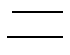

***************
Box: 
ymin:  0.49817067  xmin:  0.042000797  ymax:  0.5831957  xmax  0.15002498
left:  13.440254926681519  right:  48.00799369812012  top:  159.41461563110352  bottom  186.62261962890625
Top left point: ( 13 ,  159 ) and Bottom right point: ( 48 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 95.05 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.5 %


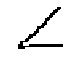

***************
Box: 
ymin:  0.49347916  xmin:  0.62331945  ymax:  0.56219256  xmax  0.7010686
left:  199.46222305297852  right:  224.34194564819336  top:  157.91333198547363  bottom  179.90161895751953
Top left point: ( 199 ,  157 ) and Bottom right point: ( 224 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 39.26 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 20.2 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 13.16 %
Symbol_id: 49 , Latex: m , Confidence Score: 8.55 %
Symbol_id: 89 , Latex: \# , Confidence Score: 5.43 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.42 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.47 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.42 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.24 %


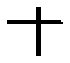

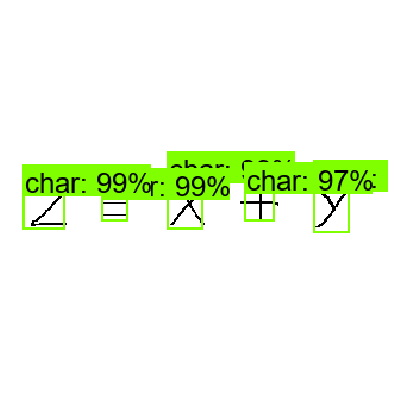

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0015.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44304729  xmin:  0.62258977  ymax:  0.5346477  xmax  0.70398235
left:  199.2287254333496  right:  225.27435302734375  top:  141.77513122558594  bottom  171.08726501464844
Top left point: ( 199 ,  141 ) and Bottom right point: ( 225 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 21.9 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 10.9 %
Symbol_id: 53 , Latex: q , Confidence Score: 8.63 %
Symbol_id: 87 , Latex: \} , Confidence Score: 7.81 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 6.13 %
Symbol_id: 0 , Latex: A , Confidence Score: 5.58 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 5.15 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 4.74 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.77 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 3.36 %
Symbol_id: 72 , Lat

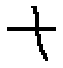

***************
Box: 
ymin:  0.4452551  xmin:  0.4039968  ymax:  0.5408191  xmax  0.5102667
left:  129.27897453308105  right:  163.28535079956055  top:  142.48163223266602  bottom  173.06211471557617
Top left point: ( 129 ,  142 ) and Bottom right point: ( 163 ,  173 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 40.21 %
Symbol_id: 79 , Latex: > , Confidence Score: 22.44 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 12.99 %
Symbol_id: 58 , Latex: w , Confidence Score: 5.75 %
Symbol_id: 22 , Latex: W , Confidence Score: 3.06 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 3.02 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.78 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.23 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.36 %


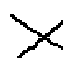

***************
Box: 
ymin:  0.4404138  xmin:  0.80491066  ymax:  0.536895  xmax  0.8992754
left:  257.5714111328125  right:  287.7681350708008  top:  140.93241691589355  bottom  171.80639266967773
Top left point: ( 257 ,  140 ) and Bottom right point: ( 287 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 46.96 %
Symbol_id: 60 , Latex: y , Confidence Score: 21.5 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 16.99 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.99 %
Symbol_id: 19 , Latex: T , Confidence Score: 2.72 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.36 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.99 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.41 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.06 %


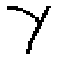

***************
Box: 
ymin:  0.45306078  xmin:  0.04506327  ymax:  0.55523604  xmax  0.13326716
left:  14.420245885848999  right:  42.64549255371094  top:  144.97944831848145  bottom  177.67553329467773
Top left point: ( 14 ,  144 ) and Bottom right point: ( 42 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 33.88 %
Symbol_id: 45 , Latex: i , Confidence Score: 32.0 %
Symbol_id: 100 , Latex: ] , Confidence Score: 23.65 %
Symbol_id: 9 , Latex: J , Confidence Score: 8.34 %
Symbol_id: 46 , Latex: j , Confidence Score: 1.27 %


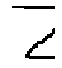

***************
Box: 
ymin:  0.48963553  xmin:  0.058787134  ymax:  0.56036156  xmax  0.1593941
left:  18.811882734298706  right:  51.00611209869385  top:  156.68336868286133  bottom  179.31570053100586
Top left point: ( 18 ,  156 ) and Bottom right point: ( 51 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 65 , Latex: \Delta , Confidence Score: 51.1 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 32.2 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 12.26 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.23 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.13 %


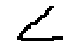

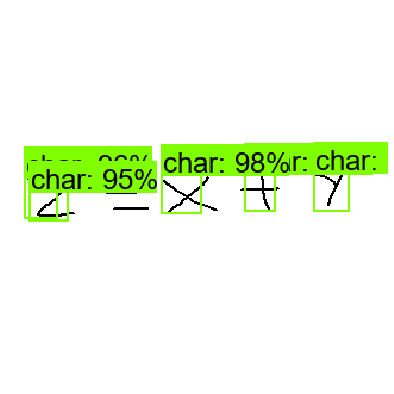

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0016.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45549616  xmin:  0.39957836  ymax:  0.5610104  xmax  0.49457017
left:  127.86507606506348  right:  158.26245307922363  top:  145.7587718963623  bottom  179.52333450317383
Top left point: ( 127 ,  145 ) and Bottom right point: ( 158 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.3 %


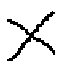

***************
Box: 
ymin:  0.45049435  xmin:  0.61130613  ymax:  0.53521544  xmax  0.70566267
left:  195.61796188354492  right:  225.81205368041992  top:  144.1581916809082  bottom  171.26893997192383
Top left point: ( 195 ,  144 ) and Bottom right point: ( 225 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 86.0 %
Symbol_id: 94 , Latex: \div , Confidence Score: 10.85 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.57 %


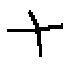

***************
Box: 
ymin:  0.45138666  xmin:  0.8003131  ymax:  0.5828865  xmax  0.902547
left:  256.1001968383789  right:  288.8150405883789  top:  144.4437313079834  bottom  186.52368545532227
Top left point: ( 256 ,  144 ) and Bottom right point: ( 288 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 41.59 %
Symbol_id: 24 , Latex: Y , Confidence Score: 27.87 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 8.73 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 8.09 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.26 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.41 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.69 %


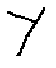

***************
Box: 
ymin:  0.4573914  xmin:  0.039210003  ymax:  0.5648978  xmax  0.13468935
left:  12.547200918197632  right:  43.10059070587158  top:  146.3652515411377  bottom  180.7672882080078
Top left point: ( 12 ,  146 ) and Bottom right point: ( 43 ,  180 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 43.28 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 36.22 %
Symbol_id: 9 , Latex: J , Confidence Score: 14.77 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.48 %


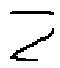

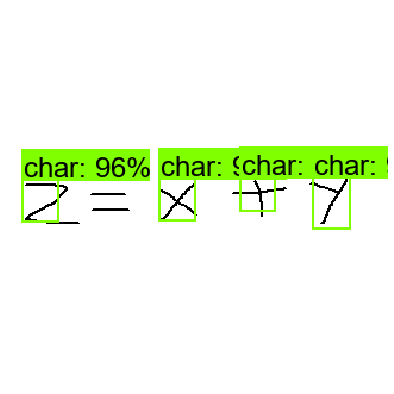

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0017.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.46560398  xmin:  0.8497243  ymax:  0.5831533  xmax  0.92757195
left:  271.9117736816406  right:  296.82302474975586  top:  148.99327278137207  bottom  186.60905838012695
Top left point: ( 271 ,  148 ) and Bottom right point: ( 296 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 94.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.97 %


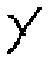

***************
Box: 
ymin:  0.4563468  xmin:  0.44077173  ymax:  0.5731185  xmax  0.5184525
left:  141.04695320129395  right:  165.9048080444336  top:  146.03097915649414  bottom  183.39792251586914
Top left point: ( 141 ,  146 ) and Bottom right point: ( 165 ,  183 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.8 %


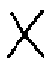

***************
Box: 
ymin:  0.45559144  xmin:  0.041644078  ymax:  0.5613819  xmax  0.13351583
left:  13.326104879379272  right:  42.725067138671875  top:  145.7892608642578  bottom  179.6422004699707
Top left point: ( 13 ,  145 ) and Bottom right point: ( 42 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 31.5 %
Symbol_id: 25 , Latex: Z , Confidence Score: 23.73 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 17.24 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 8.65 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.43 %
Symbol_id: 79 , Latex: > , Confidence Score: 3.48 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 3.39 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.48 %


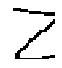

***************
Box: 
ymin:  0.5028731  xmin:  0.2623211  ymax:  0.55382025  xmax  0.33609417
left:  83.94275665283203  right:  107.55013465881348  top:  160.9193992614746  bottom  177.22248077392578
Top left point: ( 83 ,  160 ) and Bottom right point: ( 107 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 77.16 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 9.73 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.59 %
Symbol_id: 9 , Latex: J , Confidence Score: 1.89 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.56 %


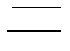

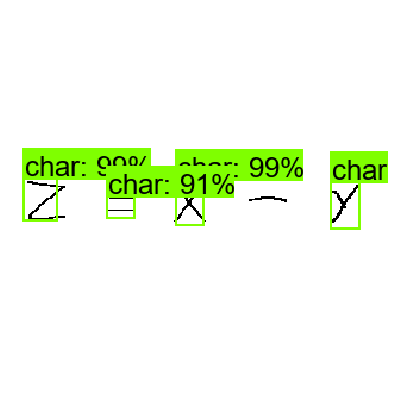

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0018.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.46570262  xmin:  0.8498506  ymax:  0.58312035  xmax  0.9276647
left:  271.9521903991699  right:  296.8527030944824  top:  149.02483940124512  bottom  186.5985107421875
Top left point: ( 271 ,  149 ) and Bottom right point: ( 296 ,  186 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 94.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.97 %


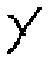

***************
Box: 
ymin:  0.4558548  xmin:  0.43942043  ymax:  0.57264644  xmax  0.51878756
left:  140.61453819274902  right:  166.01202011108398  top:  145.87353706359863  bottom  183.2468605041504
Top left point: ( 140 ,  145 ) and Bottom right point: ( 166 ,  183 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.8 %


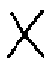

***************
Box: 
ymin:  0.503124  xmin:  0.23781061  ymax:  0.5561373  xmax  0.32400218
left:  76.09939575195312  right:  103.68069648742676  top:  160.9996795654297  bottom  177.9639434814453
Top left point: ( 76 ,  160 ) and Bottom right point: ( 103 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 52.35 %
Symbol_id: 79 , Latex: > , Confidence Score: 30.82 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 4.87 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 3.24 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 2.46 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.58 %
Symbol_id: 50 , Latex: n , Confidence Score: 1.1 %


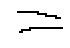

***************
Box: 
ymin:  0.4561184  xmin:  0.04198515  ymax:  0.56075394  xmax  0.13354218
left:  13.435248136520386  right:  42.733497619628906  top:  145.95788955688477  bottom  179.4412612915039
Top left point: ( 13 ,  145 ) and Bottom right point: ( 42 ,  179 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 56.96 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 16.2 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.33 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.87 %
Symbol_id: 79 , Latex: > , Confidence Score: 3.49 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.34 %


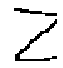

***************
Box: 
ymin:  0.50445664  xmin:  0.6266377  ymax:  0.55203706  xmax  0.70550305
left:  200.52406311035156  right:  225.7609748840332  top:  161.4261245727539  bottom  176.65185928344727
Top left point: ( 200 ,  161 ) and Bottom right point: ( 225 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 102 , Latex: \infty , Confidence Score: 89.58 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.85 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.04 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.56 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.17 %


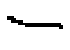

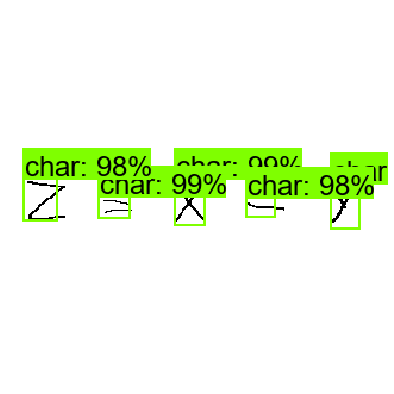

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0019.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45420805  xmin:  0.84256566  ymax:  0.5774788  xmax  0.9186719
left:  269.62100982666016  right:  293.9750099182129  top:  145.3465747833252  bottom  184.7932243347168
Top left point: ( 269 ,  145 ) and Bottom right point: ( 293 ,  184 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 28.47 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 23.37 %
Symbol_id: 89 , Latex: \# , Confidence Score: 23.24 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 8.48 %
Symbol_id: 88 , Latex: \& , Confidence Score: 4.31 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.57 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.76 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.65 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.35 %
Symbol_id: 47 , Latex: k , Confidence Score: 1.11 %


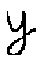

***************
Box: 
ymin:  0.5027605  xmin:  0.24029313  ymax:  0.557518  xmax  0.32729864
left:  76.89380168914795  right:  104.73556518554688  top:  160.88336944580078  bottom  178.40576171875
Top left point: ( 76 ,  160 ) and Bottom right point: ( 104 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 44.04 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 35.38 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 7.82 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.49 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 2.98 %
Symbol_id: 50 , Latex: n , Confidence Score: 1.14 %


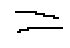

***************
Box: 
ymin:  0.46361348  xmin:  0.4027515  ymax:  0.56410813  xmax  0.5121966
left:  128.8804817199707  right:  163.90291213989258  top:  148.35631370544434  bottom  180.5146026611328
Top left point: ( 128 ,  148 ) and Bottom right point: ( 163 ,  180 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.85 %


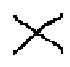

***************
Box: 
ymin:  0.50591123  xmin:  0.6300987  ymax:  0.5516765  xmax  0.7058228
left:  201.63158416748047  right:  225.8633041381836  top:  161.89159393310547  bottom  176.53648376464844
Top left point: ( 201 ,  161 ) and Bottom right point: ( 225 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 102 , Latex: \infty , Confidence Score: 85.76 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.52 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.44 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.32 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.75 %


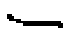

***************
Box: 
ymin:  0.49021268  xmin:  0.06539321  ymax:  0.5582861  xmax  0.14573959
left:  20.925827026367188  right:  46.636667251586914  top:  156.86805725097656  bottom  178.65154266357422
Top left point: ( 20 ,  156 ) and Bottom right point: ( 46 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 35.84 %
Symbol_id: 23 , Latex: X , Confidence Score: 22.47 %
Symbol_id: 59 , Latex: x , Confidence Score: 20.67 %
Symbol_id: 90 , Latex: \% , Confidence Score: 7.01 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.02 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.46 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.8 %


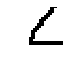

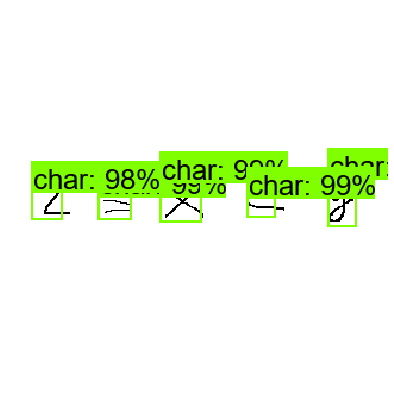

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0020.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4697352  xmin:  0.84704924  ymax:  0.5870362  xmax  0.9105283
left:  271.0557556152344  right:  291.36905670166016  top:  150.31526565551758  bottom  187.85158157348633
Top left point: ( 271 ,  150 ) and Bottom right point: ( 291 ,  187 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 94.8 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.11 %


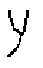

***************
Box: 
ymin:  0.47612897  xmin:  0.4142196  ymax:  0.5888052  xmax  0.50855094
left:  132.55026817321777  right:  162.73630142211914  top:  152.36126899719238  bottom  188.41766357421875
Top left point: ( 132 ,  152 ) and Bottom right point: ( 162 ,  188 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.75 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.15 %


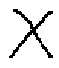

***************
Box: 
ymin:  0.50180835  xmin:  0.23184262  ymax:  0.5492115  xmax  0.312186
left:  74.1896390914917  right:  99.89952087402344  top:  160.57867050170898  bottom  175.7476806640625
Top left point: ( 74 ,  160 ) and Bottom right point: ( 99 ,  175 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 72 , Latex: \rho , Confidence Score: 43.94 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 26.48 %
Symbol_id: 83 , Latex: - , Confidence Score: 24.57 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.1 %


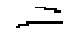

***************
Box: 
ymin:  0.5058466  xmin:  0.62819433  ymax:  0.55325955  xmax  0.7051406
left:  201.02218627929688  right:  225.64498901367188  top:  161.87091827392578  bottom  177.0430564880371
Top left point: ( 201 ,  161 ) and Bottom right point: ( 225 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 102 , Latex: \infty , Confidence Score: 82.05 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.77 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.73 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.5 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.88 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.73 %
Symbol_id: 49 , Latex: m , Confidence Score: 1.61 %


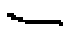

***************
Box: 
ymin:  0.4908312  xmin:  0.0665169  ymax:  0.55874246  xmax  0.14767896
left:  21.285407543182373  right:  47.2572660446167  top:  157.06598281860352  bottom  178.79758834838867
Top left point: ( 21 ,  157 ) and Bottom right point: ( 47 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 35.84 %
Symbol_id: 23 , Latex: X , Confidence Score: 22.47 %
Symbol_id: 59 , Latex: x , Confidence Score: 20.67 %
Symbol_id: 90 , Latex: \% , Confidence Score: 7.01 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.02 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.46 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.8 %


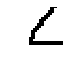

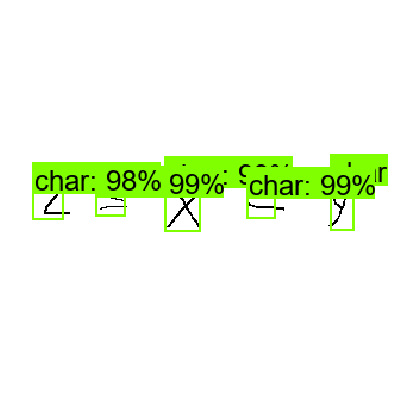

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0021.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45605192  xmin:  0.4060553  ymax:  0.5709674  xmax  0.48427185
left:  129.93769645690918  right:  154.96699333190918  top:  145.93661308288574  bottom  182.7095603942871
Top left point: ( 129 ,  145 ) and Bottom right point: ( 154 ,  182 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 60.1 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 16.91 %
Symbol_id: 60 , Latex: y , Confidence Score: 3.87 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.03 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.99 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.98 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 2.85 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.49 %


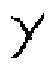

***************
Box: 
ymin:  0.46271536  xmin:  0.8224575  ymax:  0.5808202  xmax  0.9157192
left:  263.18639755249023  right:  293.03014755249023  top:  148.06891441345215  bottom  185.86246490478516
Top left point: ( 263 ,  148 ) and Bottom right point: ( 293 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.8 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.07 %


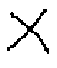

***************
Box: 
ymin:  0.49116492  xmin:  0.06499141  ymax:  0.55762374  xmax  0.14502428
left:  20.797250270843506  right:  46.40777111053467  top:  157.1727752685547  bottom  178.4395980834961
Top left point: ( 20 ,  157 ) and Bottom right point: ( 46 ,  178 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 23 , Latex: X , Confidence Score: 19.36 %
Symbol_id: 59 , Latex: x , Confidence Score: 18.33 %
Symbol_id: 92 , Latex: \times , Confidence Score: 18.14 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 12.0 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 8.75 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 7.05 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.11 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.5 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.55 %


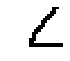

***************
Box: 
ymin:  0.5039689  xmin:  0.614428  ymax:  0.5459828  xmax  0.7007285
left:  196.6169548034668  right:  224.23311233520508  top:  161.27004623413086  bottom  174.7144889831543
Top left point: ( 196 ,  161 ) and Bottom right point: ( 224 ,  174 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 98.45 %


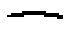

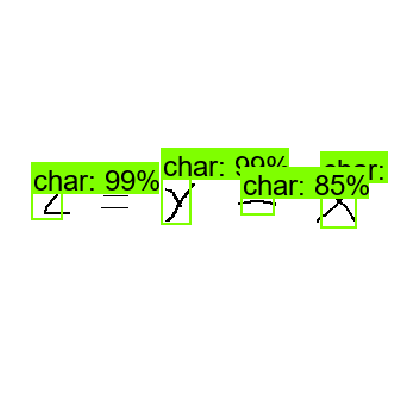

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0022.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.458706  xmin:  0.044996426  ymax:  0.54790753  xmax  0.13703327
left:  14.398856163024902  right:  43.850646018981934  top:  146.7859172821045  bottom  175.3304100036621
Top left point: ( 14 ,  146 ) and Bottom right point: ( 43 ,  175 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 55.95 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 26.04 %
Symbol_id: 79 , Latex: > , Confidence Score: 15.42 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.04 %


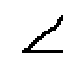

***************
Box: 
ymin:  0.45878035  xmin:  0.22903872  ymax:  0.51292866  xmax  0.31851837
left:  73.29238891601562  right:  101.92587852478027  top:  146.80971145629883  bottom  164.1371726989746
Top left point: ( 73 ,  146 ) and Bottom right point: ( 101 ,  164 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.09 %


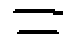

***************
Box: 
ymin:  0.45449018  xmin:  0.6037351  ymax:  0.5035254  xmax  0.6863083
left:  193.19522857666016  right:  219.6186637878418  top:  145.43685913085938  bottom  161.12812042236328
Top left point: ( 193 ,  145 ) and Bottom right point: ( 219 ,  161 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 102 , Latex: \infty , Confidence Score: 75.78 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 18.44 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.04 %


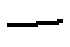

***************
Box: 
ymin:  0.41344032  xmin:  0.7643498  ymax:  0.54338545  xmax  0.8620438
left:  244.5919418334961  right:  275.8540153503418  top:  132.30090141296387  bottom  173.88334274291992
Top left point: ( 244 ,  132 ) and Bottom right point: ( 275 ,  173 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 33.86 %
Symbol_id: 79 , Latex: > , Confidence Score: 24.21 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 10.51 %
Symbol_id: 101 , Latex: \| , Confidence Score: 9.59 %
Symbol_id: 21 , Latex: V , Confidence Score: 4.67 %
Symbol_id: 57 , Latex: v , Confidence Score: 4.64 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.2 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.23 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.64 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.14 %


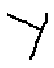

***************
Box: 
ymin:  0.43854642  xmin:  0.39633757  ymax:  0.53567386  xmax  0.5051331
left:  126.82802200317383  right:  161.6425895690918  top:  140.33485412597656  bottom  171.41563415527344
Top left point: ( 126 ,  140 ) and Bottom right point: ( 161 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.54 %


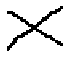

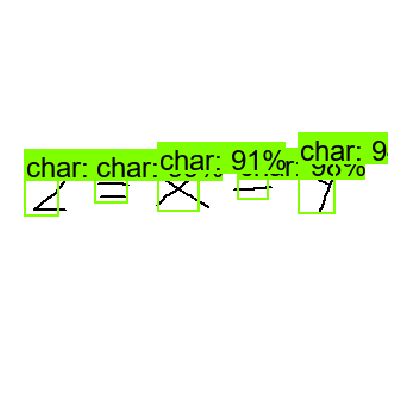

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0023.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.40484858  xmin:  0.4552488  ymax:  0.4813901  xmax  0.53461176
left:  145.6796169281006  right:  171.07576370239258  top:  129.55154418945312  bottom  154.044828414917
Top left point: ( 145 ,  129 ) and Bottom right point: ( 171 ,  154 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.2 %


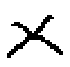

***************
Box: 
ymin:  0.41065192  xmin:  0.045072194  ymax:  0.50485885  xmax  0.1383136
left:  14.423102140426636  right:  44.26035404205322  top:  131.4086151123047  bottom  161.5548324584961
Top left point: ( 14 ,  131 ) and Bottom right point: ( 44 ,  161 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 35.24 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 22.95 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 16.59 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.77 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.42 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.13 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.02 %


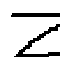

***************
Box: 
ymin:  0.39680615  xmin:  0.77796006  ymax:  0.50651133  xmax  0.8636157
left:  248.9472198486328  right:  276.3570213317871  top:  126.97796821594238  bottom  162.08362579345703
Top left point: ( 248 ,  126 ) and Bottom right point: ( 276 ,  162 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 95.26 %
Symbol_id: 21 , Latex: V , Confidence Score: 1.79 %


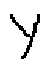

***************
Box: 
ymin:  0.41772363  xmin:  0.26983127  ymax:  0.47008443  xmax  0.36198235
left:  86.34600639343262  right:  115.8343505859375  top:  133.6715602874756  bottom  150.42701721191406
Top left point: ( 86 ,  133 ) and Bottom right point: ( 115 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 98.13 %


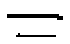

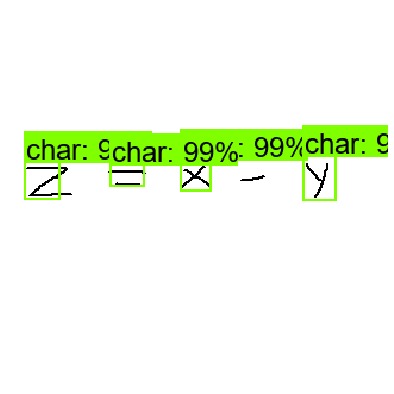

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0024.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.41063842  xmin:  0.04506455  ymax:  0.5048707  xmax  0.13830276
left:  14.420655965805054  right:  44.256882667541504  top:  131.40429496765137  bottom  161.5586280822754
Top left point: ( 14 ,  131 ) and Bottom right point: ( 44 ,  161 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 35.24 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 22.95 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 16.59 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.77 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.42 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.13 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.02 %


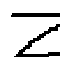

***************
Box: 
ymin:  0.4183224  xmin:  0.27149296  ymax:  0.4704538  xmax  0.36103502
left:  86.87774658203125  right:  115.53120613098145  top:  133.86317253112793  bottom  150.54521560668945
Top left point: ( 86 ,  133 ) and Bottom right point: ( 115 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 95.67 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.46 %


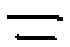

***************
Box: 
ymin:  0.39631483  xmin:  0.59985065  ymax:  0.5036976  xmax  0.692781
left:  191.95220947265625  right:  221.68991088867188  top:  126.82074546813965  bottom  161.18322372436523
Top left point: ( 191 ,  126 ) and Bottom right point: ( 221 ,  161 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.47 %
Symbol_id: 58 , Latex: w , Confidence Score: 1.65 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.45 %


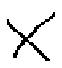

***************
Box: 
ymin:  0.39862937  xmin:  0.45361468  ymax:  0.5226967  xmax  0.5143988
left:  145.1566982269287  right:  164.6076202392578  top:  127.56139755249023  bottom  167.26293563842773
Top left point: ( 145 ,  127 ) and Bottom right point: ( 164 ,  167 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 68.94 %
Symbol_id: 89 , Latex: \# , Confidence Score: 5.97 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.19 %
Symbol_id: 40 , Latex: d , Confidence Score: 3.84 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 3.21 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.86 %
Symbol_id: 58 , Latex: w , Confidence Score: 2.84 %
Symbol_id: 22 , Latex: W , Confidence Score: 2.24 %


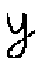

***************
Box: 
ymin:  0.39840648  xmin:  0.77547175  ymax:  0.50625926  xmax  0.8623228
left:  248.15095901489258  right:  275.94329833984375  top:  127.49007225036621  bottom  162.0029640197754
Top left point: ( 248 ,  127 ) and Bottom right point: ( 275 ,  162 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 92.18 %
Symbol_id: 21 , Latex: V , Confidence Score: 3.88 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.2 %
Symbol_id: 57 , Latex: v , Confidence Score: 1.01 %


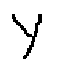

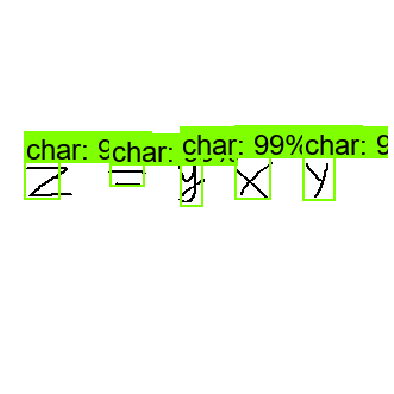

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0025.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4459519  xmin:  0.64166135  ymax:  0.55432165  xmax  0.71508527
left:  205.3316307067871  right:  228.82728576660156  top:  142.70461082458496  bottom  177.38292694091797
Top left point: ( 205 ,  142 ) and Bottom right point: ( 228 ,  177 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.93 %


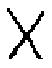

***************
Box: 
ymin:  0.4591847  xmin:  0.042542327  ymax:  0.5711181  xmax  0.11441344
left:  13.613544702529907  right:  36.612300872802734  top:  146.93910598754883  bottom  182.75779724121094
Top left point: ( 13 ,  146 ) and Bottom right point: ( 36 ,  182 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 47.69 %
Symbol_id: 60 , Latex: y , Confidence Score: 26.17 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.75 %
Symbol_id: 24 , Latex: Y , Confidence Score: 9.26 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 3.65 %


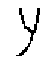

***************
Box: 
ymin:  0.44537243  xmin:  0.82317746  ymax:  0.54799724  xmax  0.92725134
left:  263.41678619384766  right:  296.7204284667969  top:  142.51917839050293  bottom  175.35911560058594
Top left point: ( 263 ,  142 ) and Bottom right point: ( 296 ,  175 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 59.39 %
Symbol_id: 61 , Latex: z , Confidence Score: 38.15 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.52 %


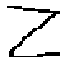

***************
Box: 
ymin:  0.46954155  xmin:  0.21892487  ymax:  0.5201516  xmax  0.3057886
left:  70.05595684051514  right:  97.85235404968262  top:  150.2532958984375  bottom  166.44851684570312
Top left point: ( 70 ,  150 ) and Bottom right point: ( 97 ,  166 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 11 , Latex: L , Confidence Score: 47.43 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 32.74 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 8.56 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 6.31 %


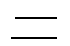

***************
Box: 
ymin:  0.4632671  xmin:  0.41454574  ymax:  0.5475759  xmax  0.5036063
left:  132.65463829040527  right:  161.15402221679688  top:  148.24546813964844  bottom  175.22428512573242
Top left point: ( 132 ,  148 ) and Bottom right point: ( 161 ,  175 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 42.71 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.46 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 12.75 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.93 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.71 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.54 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.29 %
Symbol_id: 79 , Latex: > , Confidence Score: 2.02 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.69 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.56 %


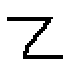

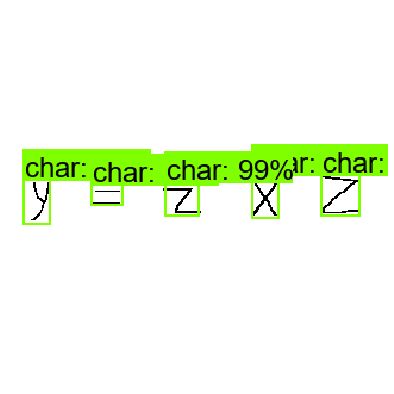

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0026.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4553372  xmin:  0.4716775  ymax:  0.54053026  xmax  0.56599885
left:  150.93680381774902  right:  181.11963272094727  top:  145.7079029083252  bottom  172.96968460083008
Top left point: ( 150 ,  145 ) and Bottom right point: ( 181 ,  172 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 99.36 %


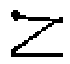

***************
Box: 
ymin:  0.44247887  xmin:  0.68241614  ymax:  0.54302543  xmax  0.76579005
left:  218.37316513061523  right:  245.05281448364258  top:  141.59323692321777  bottom  173.76813888549805
Top left point: ( 218 ,  141 ) and Bottom right point: ( 245 ,  173 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.91 %


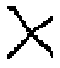

***************
Box: 
ymin:  0.44685587  xmin:  0.060742896  ymax:  0.5525758  xmax  0.16755977
left:  19.437726736068726  right:  53.61912727355957  top:  142.9938793182373  bottom  176.8242645263672
Top left point: ( 19 ,  142 ) and Bottom right point: ( 53 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.66 %


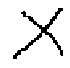

***************
Box: 
ymin:  0.47405076  xmin:  0.26641104  ymax:  0.5269237  xmax  0.3564609
left:  85.25153160095215  right:  114.0674877166748  top:  151.6962432861328  bottom  168.6155891418457
Top left point: ( 85 ,  151 ) and Bottom right point: ( 114 ,  168 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 78 , Latex: < , Confidence Score: 71.0 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 6.72 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 4.69 %
Symbol_id: 94 , Latex: \div , Confidence Score: 4.33 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.45 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.34 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.17 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.03 %


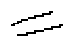

***************
Box: 
ymin:  0.45411068  xmin:  0.8701736  ymax:  0.5523895  xmax  0.94267493
left:  278.4555435180664  right:  301.65597915649414  top:  145.3154182434082  bottom  176.76464080810547
Top left point: ( 278 ,  145 ) and Bottom right point: ( 301 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 44.46 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 12.16 %
Symbol_id: 23 , Latex: X , Confidence Score: 6.23 %
Symbol_id: 10 , Latex: K , Confidence Score: 5.14 %
Symbol_id: 17 , Latex: R , Confidence Score: 4.87 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.9 %
Symbol_id: 92 , Latex: \times , Confidence Score: 3.69 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.11 %
Symbol_id: 54 , Latex: r , Confidence Score: 2.16 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.04 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.13 %
Symbol_id: 47 , Latex: k , Confidence Score: 1.09 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.04 %
Sym

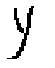

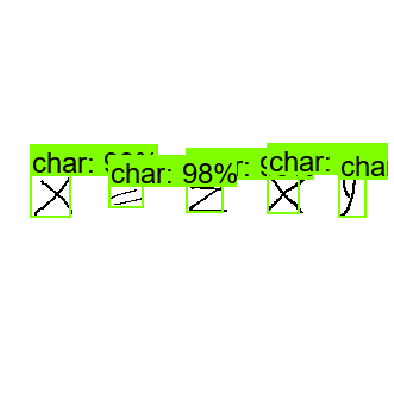

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0027.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34325448  xmin:  0.48962006  ymax:  0.4472862  xmax  0.58324057
left:  156.67841911315918  right:  186.63698196411133  top:  109.84143257141113  bottom  143.1315803527832
Top left point: ( 156 ,  109 ) and Bottom right point: ( 186 ,  143 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 44 , Latex: h , Confidence Score: 38.39 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 9.53 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 8.38 %
Symbol_id: 58 , Latex: w , Confidence Score: 6.85 %
Symbol_id: 7 , Latex: H , Confidence Score: 6.85 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 4.29 %
Symbol_id: 92 , Latex: \times , Confidence Score: 3.85 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.88 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.7 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 2.64 %
Symbol_id: 38 , 

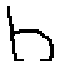

***************
Box: 
ymin:  0.35139075  xmin:  0.23849507  ymax:  0.4192601  xmax  0.3375612
left:  76.31842136383057  right:  108.01958084106445  top:  112.44503974914551  bottom  134.163236618042
Top left point: ( 76 ,  112 ) and Bottom right point: ( 108 ,  134 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 67.03 %
Symbol_id: 49 , Latex: m , Confidence Score: 8.54 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 7.76 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 3.79 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.03 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.43 %
Symbol_id: 12 , Latex: M , Confidence Score: 1.13 %


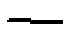

***************
Box: 
ymin:  0.34330654  xmin:  0.6696621  ymax:  0.44742188  xmax  0.7463109
left:  214.29187774658203  right:  238.81948471069336  top:  109.85809326171875  bottom  143.17500114440918
Top left point: ( 214 ,  109 ) and Bottom right point: ( 238 ,  143 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.61 %


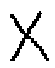

***************
Box: 
ymin:  0.35540178  xmin:  0.038754825  ymax:  0.4654251  xmax  0.12798291
left:  12.401543855667114  right:  40.954532623291016  top:  113.72857093811035  bottom  148.93603324890137
Top left point: ( 12 ,  113 ) and Bottom right point: ( 40 ,  148 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 51 , Latex: o , Confidence Score: 40.6 %
Symbol_id: 14 , Latex: O , Confidence Score: 26.9 %
Symbol_id: 26 , Latex: 0 , Confidence Score: 12.26 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 9.57 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 2.39 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.06 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 1.7 %


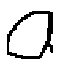

***************
Box: 
ymin:  0.35973507  xmin:  0.79964465  ymax:  0.4524365  xmax  0.90933746
left:  255.88628768920898  right:  290.98798751831055  top:  115.1152229309082  bottom  144.77968215942383
Top left point: ( 255 ,  115 ) and Bottom right point: ( 290 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 97.44 %
Symbol_id: 39 , Latex: c , Confidence Score: 1.85 %


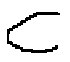

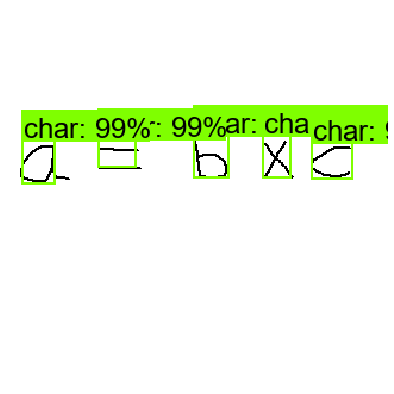

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0028.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34499308  xmin:  0.6081621  ymax:  0.42267472  xmax  0.6797982
left:  194.61187362670898  right:  217.53541946411133  top:  110.39778709411621  bottom  135.25590896606445
Top left point: ( 194 ,  110 ) and Bottom right point: ( 217 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 82.75 %
Symbol_id: 92 , Latex: \times , Confidence Score: 14.82 %


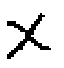

***************
Box: 
ymin:  0.35957238  xmin:  0.21953936  ymax:  0.41387388  xmax  0.30975303
left:  70.25259494781494  right:  99.12096977233887  top:  115.06316184997559  bottom  132.43964195251465
Top left point: ( 70 ,  115 ) and Bottom right point: ( 99 ,  132 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 54.15 %
Symbol_id: 60 , Latex: y , Confidence Score: 24.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 8.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 5.2 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 3.08 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.29 %


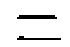

***************
Box: 
ymin:  0.3223481  xmin:  0.7809853  ymax:  0.46243444  xmax  0.866824
left:  249.9152946472168  right:  277.38367080688477  top:  103.15138816833496  bottom  147.9790210723877
Top left point: ( 249 ,  103 ) and Bottom right point: ( 277 ,  147 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 40.48 %
Symbol_id: 60 , Latex: y , Confidence Score: 36.03 %
Symbol_id: 56 , Latex: u , Confidence Score: 6.83 %
Symbol_id: 79 , Latex: > , Confidence Score: 6.24 %
Symbol_id: 20 , Latex: U , Confidence Score: 2.49 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.77 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.13 %


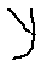

***************
Box: 
ymin:  0.3497132  xmin:  0.04024694  ymax:  0.44152594  xmax  0.13174485
left:  12.879021167755127  right:  42.15835094451904  top:  111.9082260131836  bottom  141.28829956054688
Top left point: ( 12 ,  111 ) and Bottom right point: ( 42 ,  141 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 45.3 %
Symbol_id: 25 , Latex: Z , Confidence Score: 26.52 %
Symbol_id: 61 , Latex: z , Confidence Score: 22.06 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.73 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.77 %


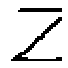

***************
Box: 
ymin:  0.33218852  xmin:  0.40984812  ymax:  0.44750968  xmax  0.5036422
left:  131.15139961242676  right:  161.1655044555664  top:  106.30032539367676  bottom  143.2030963897705
Top left point: ( 131 ,  106 ) and Bottom right point: ( 161 ,  143 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 33.62 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 26.83 %
Symbol_id: 79 , Latex: > , Confidence Score: 10.3 %
Symbol_id: 24 , Latex: Y , Confidence Score: 6.58 %
Symbol_id: 21 , Latex: V , Confidence Score: 6.4 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.46 %
Symbol_id: 57 , Latex: v , Confidence Score: 4.21 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.03 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.14 %


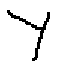

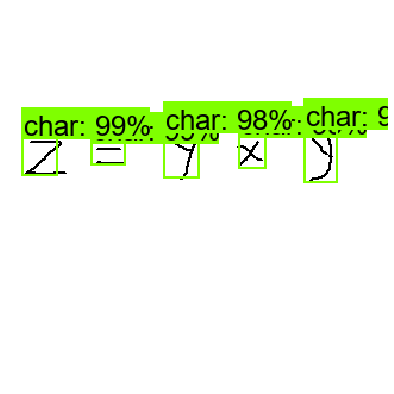

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0029.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34439418  xmin:  0.48200783  ymax:  0.44109932  xmax  0.58014935
left:  154.24250602722168  right:  185.6477928161621  top:  110.20613670349121  bottom  141.15178108215332
Top left point: ( 154 ,  110 ) and Bottom right point: ( 185 ,  141 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 38.36 %
Symbol_id: 22 , Latex: W , Confidence Score: 25.53 %
Symbol_id: 58 , Latex: w , Confidence Score: 20.58 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 4.25 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 3.73 %
Symbol_id: 57 , Latex: v , Confidence Score: 2.15 %


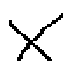

***************
Box: 
ymin:  0.3407044  xmin:  0.049480762  ymax:  0.4609799  xmax  0.15277235
left:  15.83384394645691  right:  48.887152671813965  top:  109.02541160583496  bottom  147.51357078552246
Top left point: ( 15 ,  109 ) and Bottom right point: ( 48 ,  147 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 59.4 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 33.26 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.94 %


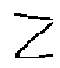

***************
Box: 
ymin:  0.35264978  xmin:  0.87456894  ymax:  0.45158872  xmax  0.9479117
left:  279.862060546875  right:  303.33173751831055  top:  112.84792900085449  bottom  144.50839042663574
Top left point: ( 279 ,  112 ) and Bottom right point: ( 303 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 40.37 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 21.35 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 12.4 %
Symbol_id: 10 , Latex: K , Confidence Score: 7.0 %
Symbol_id: 54 , Latex: r , Confidence Score: 3.23 %
Symbol_id: 47 , Latex: k , Confidence Score: 2.69 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.5 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.31 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.28 %
Symbol_id: 21 , Latex: V , Confidence Score: 1.1 %


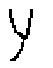

***************
Box: 
ymin:  0.35503554  xmin:  0.68578964  ymax:  0.42590174  xmax  0.7545019
left:  219.45268630981445  right:  241.44060134887695  top:  113.61137390136719  bottom  136.2885570526123
Top left point: ( 219 ,  113 ) and Bottom right point: ( 241 ,  136 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 54.58 %
Symbol_id: 94 , Latex: \div , Confidence Score: 25.1 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 3.98 %
Symbol_id: 78 , Latex: < , Confidence Score: 3.06 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 3.03 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 2.63 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.85 %
Symbol_id: 48 , Latex: l , Confidence Score: 1.33 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.08 %


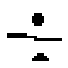

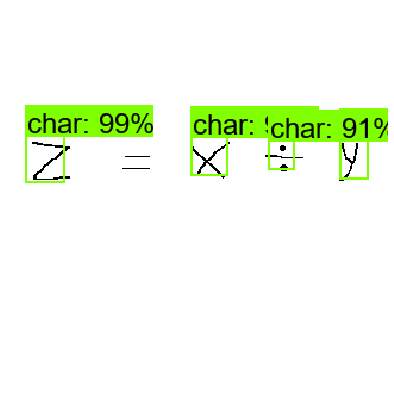

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0030.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34908977  xmin:  0.4764154  ymax:  0.46916768  xmax  0.5655393
left:  152.4529266357422  right:  180.97257614135742  top:  111.70872688293457  bottom  150.13365745544434
Top left point: ( 152 ,  111 ) and Bottom right point: ( 180 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.38 %


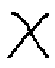

***************
Box: 
ymin:  0.37650475  xmin:  0.2759914  ymax:  0.4246145  xmax  0.36042002
left:  88.31725120544434  right:  115.33440589904785  top:  120.48151969909668  bottom  135.87663650512695
Top left point: ( 88 ,  120 ) and Bottom right point: ( 115 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 51.69 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 38.54 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 5.74 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.56 %


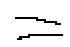

***************
Box: 
ymin:  0.34113356  xmin:  0.050393414  ymax:  0.4580234  xmax  0.15195957
left:  16.125892400741577  right:  48.62706184387207  top:  109.16274070739746  bottom  146.5674877166748
Top left point: ( 16 ,  109 ) and Bottom right point: ( 48 ,  146 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 60.14 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 35.13 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.65 %


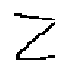

***************
Box: 
ymin:  0.35249543  xmin:  0.86683446  ymax:  0.48032746  xmax  0.9558201
left:  277.3870277404785  right:  305.8624267578125  top:  112.79853820800781  bottom  153.70478630065918
Top left point: ( 277 ,  112 ) and Bottom right point: ( 305 ,  153 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 35.51 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 27.59 %
Symbol_id: 47 , Latex: k , Confidence Score: 7.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 6.7 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 5.8 %
Symbol_id: 89 , Latex: \# , Confidence Score: 5.35 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.08 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.29 %


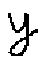

***************
Box: 
ymin:  0.35025263  xmin:  0.67706716  ymax:  0.44312152  xmax  0.75766826
left:  216.66149139404297  right:  242.45384216308594  top:  112.08084106445312  bottom  141.79888725280762
Top left point: ( 216 ,  112 ) and Bottom right point: ( 242 ,  141 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 82.26 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 5.67 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.29 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.64 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.51 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.05 %


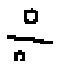

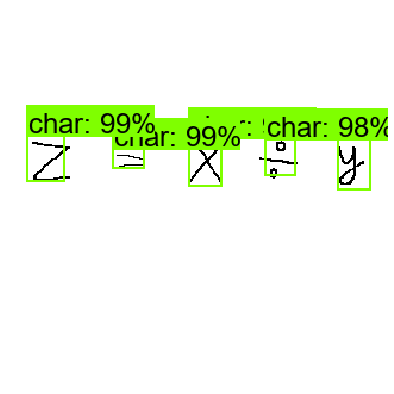

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0031.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3495477  xmin:  0.4781805  ymax:  0.468901  xmax  0.56396264
left:  153.01775932312012  right:  180.46804428100586  top:  111.85526847839355  bottom  150.0483226776123
Top left point: ( 153 ,  111 ) and Bottom right point: ( 180 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.59 %


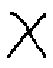

***************
Box: 
ymin:  0.35161582  xmin:  0.86754435  ymax:  0.47962388  xmax  0.9563572
left:  277.6141929626465  right:  306.03429794311523  top:  112.51706123352051  bottom  153.479642868042
Top left point: ( 277 ,  112 ) and Bottom right point: ( 306 ,  153 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 47.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 11.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 11.81 %
Symbol_id: 47 , Latex: k , Confidence Score: 10.65 %
Symbol_id: 89 , Latex: \# , Confidence Score: 5.22 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 5.03 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 2.82 %


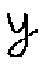

***************
Box: 
ymin:  0.3895774  xmin:  0.07134745  ymax:  0.45117435  xmax  0.15053491
left:  22.83118486404419  right:  48.17117214202881  top:  124.66476440429688  bottom  144.37579154968262
Top left point: ( 22 ,  124 ) and Bottom right point: ( 48 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 69.2 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.7 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.46 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.82 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.72 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.61 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.52 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.41 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.31 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.11 %


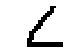

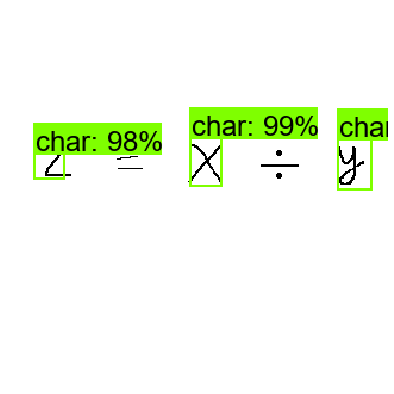

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0032.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34435844  xmin:  0.45344552  ymax:  0.43462983  xmax  0.5514126
left:  145.1025676727295  right:  176.4520263671875  top:  110.1947021484375  bottom  139.08154487609863
Top left point: ( 145 ,  110 ) and Bottom right point: ( 176 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.42 %


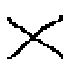

***************
Box: 
ymin:  0.3496275  xmin:  0.8435566  ymax:  0.4700366  xmax  0.9223675
left:  269.93810653686523  right:  295.1576042175293  top:  111.88079833984375  bottom  150.41171073913574
Top left point: ( 269 ,  111 ) and Bottom right point: ( 295 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 87.47 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 5.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.37 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.18 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.03 %


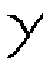

***************
Box: 
ymin:  0.38967073  xmin:  0.07065077  ymax:  0.45075497  xmax  0.14737467
left:  22.60824680328369  right:  47.15989589691162  top:  124.69463348388672  bottom  144.24159049987793
Top left point: ( 22 ,  124 ) and Bottom right point: ( 47 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 27.45 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 22.05 %
Symbol_id: 92 , Latex: \times , Confidence Score: 11.37 %
Symbol_id: 23 , Latex: X , Confidence Score: 6.85 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.96 %
Symbol_id: 59 , Latex: x , Confidence Score: 4.08 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 3.91 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.61 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.37 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.32 %
Symbol_id: 57 , Latex: v , Confidence Score: 1.25 %
Symbol_id: 21 , Latex: V , Confidence Score: 1.23 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.

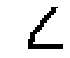

***************
Box: 
ymin:  0.3737063  xmin:  0.6603767  ymax:  0.43607926  xmax  0.7420313
left:  211.32055282592773  right:  237.45000839233398  top:  119.58601951599121  bottom  139.5453643798828
Top left point: ( 211 ,  119 ) and Bottom right point: ( 237 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 62.01 %
Symbol_id: 84 , Latex: + , Confidence Score: 34.74 %


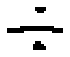

***************
Box: 
ymin:  0.37670752  xmin:  0.26913616  ymax:  0.4228723  xmax  0.35193667
left:  86.12357139587402  right:  112.6197338104248  top:  120.54640769958496  bottom  135.3191375732422
Top left point: ( 86 ,  120 ) and Bottom right point: ( 112 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 59.74 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 9.84 %
Symbol_id: 78 , Latex: < , Confidence Score: 3.45 %
Symbol_id: 50 , Latex: n , Confidence Score: 2.86 %
Symbol_id: 105 , Latex: //( , Confidence Score: 2.55 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.87 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.82 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.59 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.52 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.27 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 1.24 %
Symbol_id: 54 , Latex: r , Confidence Score: 1.21 %


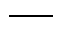

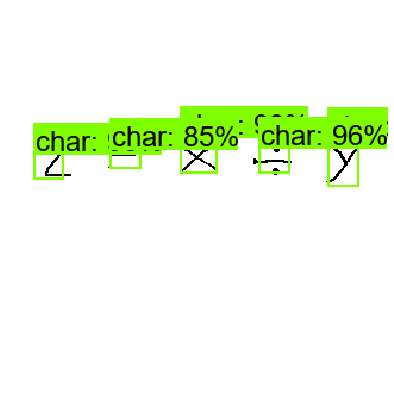

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0033.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34702  xmin:  0.43379924  ymax:  0.46756878  xmax  0.50883186
left:  138.8157558441162  right:  162.8261947631836  top:  111.04640007019043  bottom  149.62201118469238
Top left point: ( 138 ,  111 ) and Bottom right point: ( 162 ,  149 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 50.83 %
Symbol_id: 92 , Latex: \times , Confidence Score: 30.14 %
Symbol_id: 79 , Latex: > , Confidence Score: 13.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.39 %


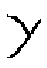

***************
Box: 
ymin:  0.3495489  xmin:  0.84341985  ymax:  0.4698122  xmax  0.92248803
left:  269.8943519592285  right:  295.19617080688477  top:  111.85564994812012  bottom  150.33990859985352
Top left point: ( 269 ,  111 ) and Bottom right point: ( 295 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 87.47 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 5.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.37 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.18 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.03 %


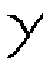

***************
Box: 
ymin:  0.35742074  xmin:  0.047943935  ymax:  0.45328847  xmax  0.13488477
left:  15.342059135437012  right:  43.16312789916992  top:  114.37463760375977  bottom  145.05230903625488
Top left point: ( 15 ,  114 ) and Bottom right point: ( 43 ,  145 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.33 %


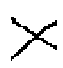

***************
Box: 
ymin:  0.37418878  xmin:  0.6593932  ymax:  0.43632427  xmax  0.74417853
left:  211.00582122802734  right:  238.1371307373047  top:  119.74040985107422  bottom  139.62376594543457
Top left point: ( 211 ,  119 ) and Bottom right point: ( 238 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 65.23 %
Symbol_id: 84 , Latex: + , Confidence Score: 33.71 %


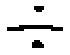

***************
Box: 
ymin:  0.37392694  xmin:  0.27091488  ymax:  0.42384028  xmax  0.35420996
left:  86.69276237487793  right:  113.34718704223633  top:  119.65662002563477  bottom  135.62889099121094
Top left point: ( 86 ,  119 ) and Bottom right point: ( 113 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 11 , Latex: L , Confidence Score: 84.15 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 8.88 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.06 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.02 %


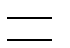

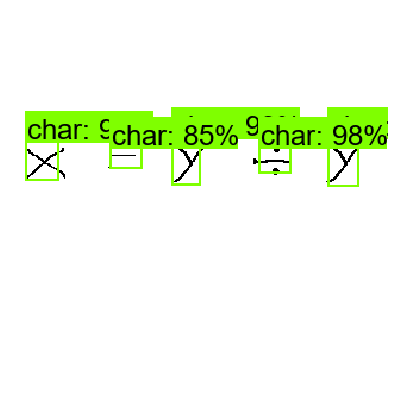

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0034.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3552476  xmin:  0.2886568  ymax:  0.4250997  xmax  0.3894635
left:  92.37017631530762  right:  124.62832450866699  top:  113.67922782897949  bottom  136.03190422058105
Top left point: ( 92 ,  113 ) and Bottom right point: ( 124 ,  136 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 51.31 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 21.48 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 13.05 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.93 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.37 %


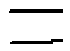

***************
Box: 
ymin:  0.32935283  xmin:  0.060828116  ymax:  0.45384216  xmax  0.1648386
left:  19.464997053146362  right:  52.748351097106934  top:  105.39290428161621  bottom  145.2294921875
Top left point: ( 19 ,  105 ) and Bottom right point: ( 52 ,  145 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 86.12 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 5.53 %
Symbol_id: 79 , Latex: > , Confidence Score: 4.84 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.12 %


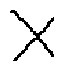

***************
Box: 
ymin:  0.3356338  xmin:  0.4851148  ymax:  0.4704166  xmax  0.5661291
left:  155.2367401123047  right:  181.16130828857422  top:  107.4028205871582  bottom  150.5333137512207
Top left point: ( 155 ,  107 ) and Bottom right point: ( 181 ,  150 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 37.52 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 30.76 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 7.92 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 7.75 %
Symbol_id: 24 , Latex: Y , Confidence Score: 6.2 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.19 %
Symbol_id: 79 , Latex: > , Confidence Score: 2.18 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.1 %


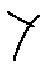

***************
Box: 
ymin:  0.33554375  xmin:  0.051276196  ymax:  0.45044786  xmax  0.13197972
left:  16.408382654190063  right:  42.23351001739502  top:  107.3740005493164  bottom  144.14331436157227
Top left point: ( 16 ,  107 ) and Bottom right point: ( 42 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 82.35 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 11.6 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.83 %


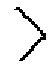

***************
Box: 
ymin:  0.3959125  xmin:  0.8077094  ymax:  0.47616267  xmax  0.9057315
left:  258.4670066833496  right:  289.83407974243164  top:  126.6919994354248  bottom  152.37205505371094
Top left point: ( 258 ,  126 ) and Bottom right point: ( 289 ,  152 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 35.05 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 32.62 %
Symbol_id: 61 , Latex: z , Confidence Score: 17.37 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 7.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.48 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.19 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.05 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.01 %


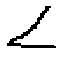

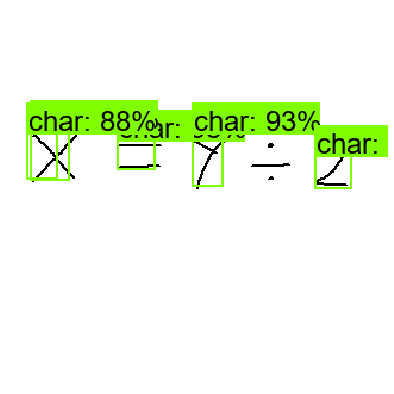

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0035.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.33914936  xmin:  0.7013649  ymax:  0.44150612  xmax  0.7796347
left:  224.43675994873047  right:  249.4831085205078  top:  108.52779388427734  bottom  141.28195762634277
Top left point: ( 224 ,  108 ) and Bottom right point: ( 249 ,  141 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 3 , Latex: D , Confidence Score: 36.74 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 17.27 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 16.62 %
Symbol_id: 89 , Latex: \# , Confidence Score: 12.64 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 4.07 %
Symbol_id: 20 , Latex: U , Confidence Score: 3.78 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.59 %
Symbol_id: 50 , Latex: n , Confidence Score: 1.32 %


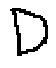

***************
Box: 
ymin:  0.3408109  xmin:  0.37873912  ymax:  0.42817363  xmax  0.4533053
left:  121.19651794433594  right:  145.05769729614258  top:  109.05948638916016  bottom  137.01556205749512
Top left point: ( 121 ,  109 ) and Bottom right point: ( 145 ,  137 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 89.66 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 7.54 %


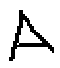

***************
Box: 
ymin:  0.34919736  xmin:  0.08105087  ymax:  0.4580361  xmax  0.15440679
left:  25.936279296875  right:  49.41017150878906  top:  111.74315452575684  bottom  146.5715503692627
Top left point: ( 25 ,  111 ) and Bottom right point: ( 49 ,  146 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 89.78 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 8.22 %


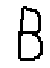

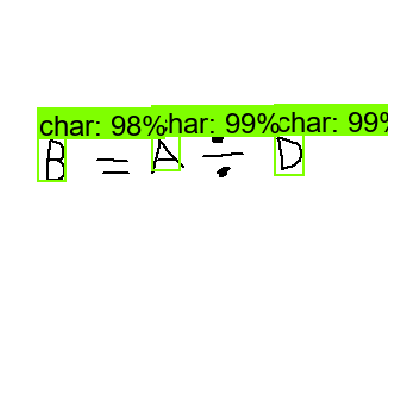

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0036.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34380117  xmin:  0.5563106  ymax:  0.42626148  xmax  0.64896977
left:  178.01939010620117  right:  207.67032623291016  top:  110.0163745880127  bottom  136.4036750793457
Top left point: ( 178 ,  110 ) and Bottom right point: ( 207 ,  136 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 13 , Latex: N , Confidence Score: 56.25 %
Symbol_id: 90 , Latex: \% , Confidence Score: 23.01 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 16.8 %


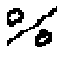

***************
Box: 
ymin:  0.32410344  xmin:  0.39411494  ymax:  0.43279377  xmax  0.44362447
left:  126.11678123474121  right:  141.95982933044434  top:  103.71310234069824  bottom  138.49400520324707
Top left point: ( 126 ,  103 ) and Bottom right point: ( 141 ,  138 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 99.77 %


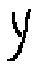

***************
Box: 
ymin:  0.3357646  xmin:  0.76840585  ymax:  0.43031928  xmax  0.8703415
left:  245.88987350463867  right:  278.50927352905273  top:  107.44466781616211  bottom  137.70216941833496
Top left point: ( 245 ,  107 ) and Bottom right point: ( 278 ,  137 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.94 %


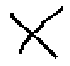

***************
Box: 
ymin:  0.34916422  xmin:  0.2302531  ymax:  0.4011337  xmax  0.30340236
left:  73.68099212646484  right:  97.0887565612793  top:  111.7325496673584  bottom  128.36277961730957
Top left point: ( 73 ,  111 ) and Bottom right point: ( 97 ,  128 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 90.65 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 6.02 %


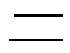

***************
Box: 
ymin:  0.3409112  xmin:  0.045042884  ymax:  0.42279863  xmax  0.16544732
left:  14.41372275352478  right:  52.94314384460449  top:  109.09158706665039  bottom  135.29556274414062
Top left point: ( 14 ,  109 ) and Bottom right point: ( 52 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 52.43 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.36 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.5 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.04 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.44 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 3.39 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.14 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.67 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.48 %
Symbol_id: 106 , Latex: //) , Confidence Score: 2.42 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.04 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.18 %


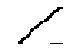

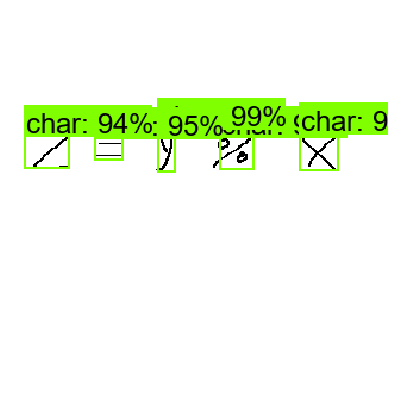

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0037.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3261731  xmin:  0.3340298  ymax:  0.43505308  xmax  0.40642986
left:  106.88953399658203  right:  130.05755424499512  top:  104.37539100646973  bottom  139.21698570251465
Top left point: ( 106 ,  104 ) and Bottom right point: ( 130 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 36.51 %
Symbol_id: 60 , Latex: y , Confidence Score: 34.45 %
Symbol_id: 79 , Latex: > , Confidence Score: 9.06 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 5.47 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.34 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 2.36 %
Symbol_id: 87 , Latex: \} , Confidence Score: 2.27 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.42 %


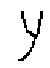

***************
Box: 
ymin:  0.33379075  xmin:  0.5735766  ymax:  0.42998144  xmax  0.65938765
left:  183.5445213317871  right:  211.00404739379883  top:  106.81303977966309  bottom  137.59406089782715
Top left point: ( 183 ,  106 ) and Bottom right point: ( 211 ,  137 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 59.08 %
Symbol_id: 90 , Latex: \% , Confidence Score: 23.1 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.48 %
Symbol_id: 10 , Latex: K , Confidence Score: 2.47 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.81 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.71 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.34 %
Symbol_id: 13 , Latex: N , Confidence Score: 1.01 %
Symbol_id: 44 , Latex: h , Confidence Score: 1.01 %


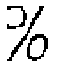

***************
Box: 
ymin:  0.3367242  xmin:  0.7530562  ymax:  0.42073855  xmax  0.86250603
left:  240.9779930114746  right:  276.0019302368164  top:  107.75174140930176  bottom  134.6363353729248
Top left point: ( 240 ,  107 ) and Bottom right point: ( 276 ,  134 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.03 %


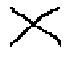

***************
Box: 
ymin:  0.29062077  xmin:  0.029853424  ymax:  0.40828982  xmax  0.122080676
left:  9.553095698356628  right:  39.0658164024353  top:  92.99864768981934  bottom  130.65274238586426
Top left point: ( 9 ,  92 ) and Bottom right point: ( 39 ,  130 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 97.27 %
Symbol_id: 79 , Latex: > , Confidence Score: 2.24 %


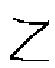

***************
Box: 
ymin:  0.34639367  xmin:  0.22892463  ymax:  0.4018901  xmax  0.30915096
left:  73.2558822631836  right:  98.92830848693848  top:  110.84597587585449  bottom  128.60483169555664
Top left point: ( 73 ,  110 ) and Bottom right point: ( 98 ,  128 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 92.31 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 5.06 %


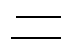

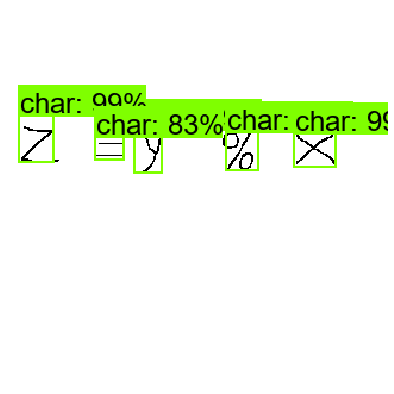

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0038.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.32494345  xmin:  0.33719054  ymax:  0.43253824  xmax  0.40722606
left:  107.90097236633301  right:  130.3123378753662  top:  103.98190498352051  bottom  138.4122371673584
Top left point: ( 107 ,  103 ) and Bottom right point: ( 130 ,  138 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 58.1 %
Symbol_id: 60 , Latex: y , Confidence Score: 15.72 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 7.48 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.7 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 2.8 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.07 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.63 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 1.47 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.26 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.11 %


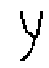

***************
Box: 
ymin:  0.33959565  xmin:  0.5297262  ymax:  0.4244511  xmax  0.626022
left:  169.51238632202148  right:  200.32703399658203  top:  108.67060661315918  bottom  135.82435607910156
Top left point: ( 169 ,  108 ) and Bottom right point: ( 200 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.55 %


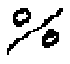

***************
Box: 
ymin:  0.33651695  xmin:  0.7534364  ymax:  0.42159376  xmax  0.8627931
left:  241.0996437072754  right:  276.09378814697266  top:  107.68542289733887  bottom  134.91000175476074
Top left point: ( 241 ,  107 ) and Bottom right point: ( 276 ,  134 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.03 %


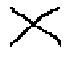

***************
Box: 
ymin:  0.29062104  xmin:  0.02985332  ymax:  0.40828893  xmax  0.12208147
left:  9.553062319755554  right:  39.06607151031494  top:  92.99873352050781  bottom  130.65245628356934
Top left point: ( 9 ,  92 ) and Bottom right point: ( 39 ,  130 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 97.27 %
Symbol_id: 79 , Latex: > , Confidence Score: 2.24 %


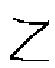

***************
Box: 
ymin:  0.34711012  xmin:  0.22891591  ymax:  0.4009349  xmax  0.30889234
left:  73.2530927658081  right:  98.84554862976074  top:  111.07523918151855  bottom  128.29916954040527
Top left point: ( 73 ,  111 ) and Bottom right point: ( 98 ,  128 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 96.0 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.81 %


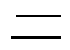

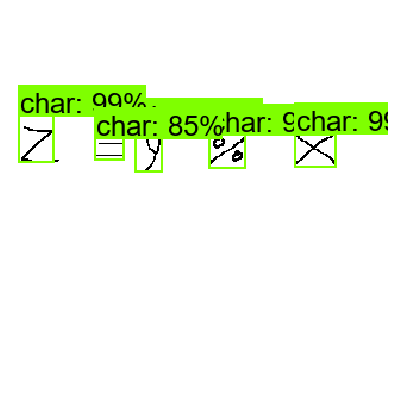

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0039.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3252774  xmin:  0.33790135  ymax:  0.43618652  xmax  0.40575033
left:  108.12843322753906  right:  129.84010696411133  top:  104.08876419067383  bottom  139.57968711853027
Top left point: ( 108 ,  104 ) and Bottom right point: ( 129 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 35.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 27.52 %
Symbol_id: 79 , Latex: > , Confidence Score: 17.13 %
Symbol_id: 24 , Latex: Y , Confidence Score: 10.52 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.83 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 1.38 %


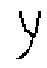

***************
Box: 
ymin:  0.3370547  xmin:  0.75399894  ymax:  0.42156988  xmax  0.86294746
left:  241.27965927124023  right:  276.1431884765625  top:  107.85750389099121  bottom  134.90236282348633
Top left point: ( 241 ,  107 ) and Bottom right point: ( 276 ,  134 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.03 %


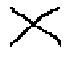

***************
Box: 
ymin:  0.34576046  xmin:  0.19384375  ymax:  0.40251336  xmax  0.28021145
left:  62.03000068664551  right:  89.66766357421875  top:  110.64334869384766  bottom  128.80427360534668
Top left point: ( 62 ,  110 ) and Bottom right point: ( 89 ,  128 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 89.3 %
Symbol_id: 79 , Latex: > , Confidence Score: 7.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.66 %


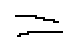

***************
Box: 
ymin:  0.3251042  xmin:  0.55027336  ymax:  0.42233968  xmax  0.63268644
left:  176.08747482299805  right:  202.45965957641602  top:  104.03334617614746  bottom  135.14869689941406
Top left point: ( 176 ,  104 ) and Bottom right point: ( 202 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.45 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.19 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.13 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.19 %


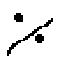

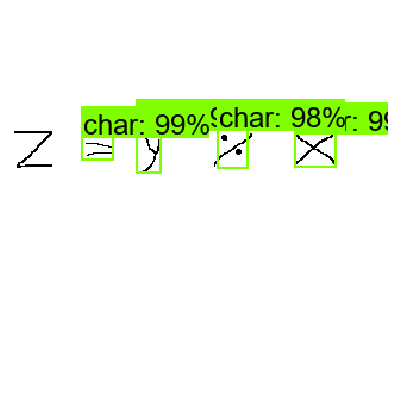

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0040.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.32542026  xmin:  0.3371277  ymax:  0.43757963  xmax  0.4042656
left:  107.880859375  right:  129.3649959564209  top:  104.13448333740234  bottom  140.02548217773438
Top left point: ( 107 ,  104 ) and Bottom right point: ( 129 ,  140 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 69.16 %
Symbol_id: 60 , Latex: y , Confidence Score: 8.68 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 5.4 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.63 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.79 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.56 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.1 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.07 %


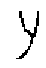

***************
Box: 
ymin:  0.35251272  xmin:  0.1872984  ymax:  0.40544614  xmax  0.26545987
left:  59.9354887008667  right:  84.94715690612793  top:  112.80406951904297  bottom  129.74276542663574
Top left point: ( 59 ,  112 ) and Bottom right point: ( 84 ,  129 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 78 , Latex: < , Confidence Score: 55.5 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 28.2 %
Symbol_id: 11 , Latex: L , Confidence Score: 2.58 %
Symbol_id: 105 , Latex: //( , Confidence Score: 2.29 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 2.03 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.76 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.71 %
Symbol_id: 48 , Latex: l , Confidence Score: 1.56 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.02 %


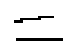

***************
Box: 
ymin:  0.33694586  xmin:  0.753197  ymax:  0.4212806  xmax  0.86299753
left:  241.02304458618164  right:  276.1592102050781  top:  107.82267570495605  bottom  134.80978965759277
Top left point: ( 241 ,  107 ) and Bottom right point: ( 276 ,  134 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.03 %


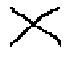

***************
Box: 
ymin:  0.30420238  xmin:  0.55141276  ymax:  0.4234395  xmax  0.659651
left:  176.45208358764648  right:  211.08831405639648  top:  97.34476089477539  bottom  135.50064086914062
Top left point: ( 176 ,  97 ) and Bottom right point: ( 211 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 62.52 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 15.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 5.17 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.4 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.58 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.47 %
Symbol_id: 10 , Latex: K , Confidence Score: 1.11 %


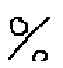

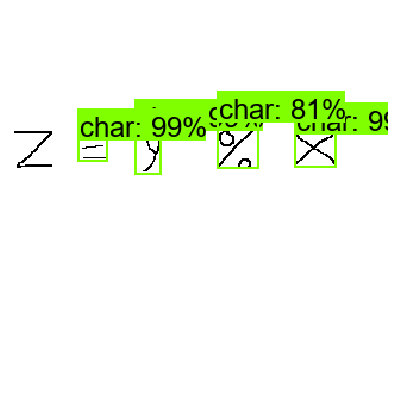

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0041.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.30073258  xmin:  0.3515289  ymax:  0.4164114  xmax  0.4703693
left:  112.4892520904541  right:  150.51817893981934  top:  96.23442649841309  bottom  133.25164794921875
Top left point: ( 112 ,  96 ) and Bottom right point: ( 150 ,  133 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.3 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.85 %


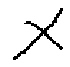

***************
Box: 
ymin:  0.3067927  xmin:  0.6213591  ymax:  0.41767964  xmax  0.69245404
left:  198.8349151611328  right:  221.5852928161621  top:  98.17366600036621  bottom  133.65748405456543
Top left point: ( 198 ,  98 ) and Bottom right point: ( 221 ,  133 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 93.46 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.54 %
Symbol_id: 10 , Latex: K , Confidence Score: 1.13 %


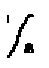

***************
Box: 
ymin:  0.32267627  xmin:  0.221542  ymax:  0.37538853  xmax  0.304572
left:  70.89344024658203  right:  97.4630355834961  top:  103.25640678405762  bottom  120.12433052062988
Top left point: ( 70 ,  103 ) and Bottom right point: ( 97 ,  120 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 45.02 %
Symbol_id: 49 , Latex: m , Confidence Score: 24.95 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 15.38 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 9.16 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.12 %


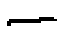

***************
Box: 
ymin:  0.32886493  xmin:  0.028957501  ymax:  0.40745902  xmax  0.11696823
left:  9.266400337219238  right:  37.42983341217041  top:  105.23677825927734  bottom  130.3868865966797
Top left point: ( 9 ,  105 ) and Bottom right point: ( 37 ,  130 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 85.56 %
Symbol_id: 61 , Latex: z , Confidence Score: 13.01 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.27 %


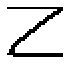

***************
Box: 
ymin:  0.28939834  xmin:  0.751394  ymax:  0.4051664  xmax  0.86374676
left:  240.44607162475586  right:  276.39896392822266  top:  92.60746955871582  bottom  129.6532440185547
Top left point: ( 240 ,  92 ) and Bottom right point: ( 276 ,  129 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 24.42 %
Symbol_id: 60 , Latex: y , Confidence Score: 16.7 %
Symbol_id: 79 , Latex: > , Confidence Score: 15.4 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 12.43 %
Symbol_id: 24 , Latex: Y , Confidence Score: 9.72 %
Symbol_id: 101 , Latex: \| , Confidence Score: 6.13 %
Symbol_id: 57 , Latex: v , Confidence Score: 2.71 %
Symbol_id: 21 , Latex: V , Confidence Score: 2.14 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.82 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.8 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.51 %


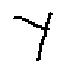

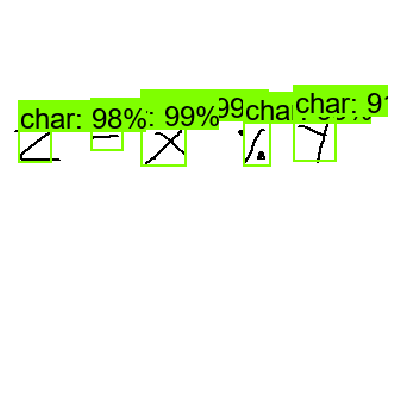

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0042.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.28760102  xmin:  0.04803375  ymax:  0.37392667  xmax  0.1330095
left:  15.370800495147705  right:  42.56303787231445  top:  92.03232765197754  bottom  119.65653419494629
Top left point: ( 15 ,  92 ) and Bottom right point: ( 42 ,  119 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 90.31 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 5.82 %


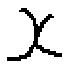

***************
Box: 
ymin:  0.27590877  xmin:  0.39961848  ymax:  0.38275966  xmax  0.48282477
left:  127.8779125213623  right:  154.50392723083496  top:  88.29080581665039  bottom  122.48309135437012
Top left point: ( 127 ,  88 ) and Bottom right point: ( 154 ,  122 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 96.77 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.89 %


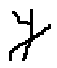

***************
Box: 
ymin:  0.2676097  xmin:  0.5633151  ymax:  0.3335565  xmax  0.6417932
left:  180.2608299255371  right:  205.37382125854492  top:  85.63509941101074  bottom  106.73808097839355
Top left point: ( 180 ,  85 ) and Bottom right point: ( 205 ,  106 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 85.54 %
Symbol_id: 38 , Latex: b , Confidence Score: 4.97 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 3.11 %
Symbol_id: 44 , Latex: h , Confidence Score: 2.02 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 1.99 %


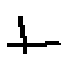

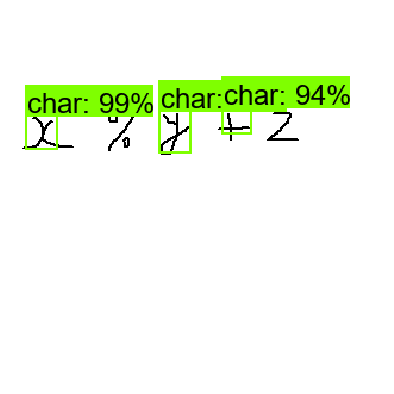

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0043.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45546952  xmin:  0.20654105  ymax:  0.5104651  xmax  0.2909017
left:  66.09313488006592  right:  93.08854103088379  top:  145.75024604797363  bottom  163.34882736206055
Top left point: ( 66 ,  145 ) and Bottom right point: ( 93 ,  163 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.77 %


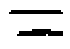

***************
Box: 
ymin:  0.45762452  xmin:  0.041513074  ymax:  0.55002654  xmax  0.1265624
left:  13.284183740615845  right:  40.49996852874756  top:  146.439847946167  bottom  176.00849151611328
Top left point: ( 13 ,  146 ) and Bottom right point: ( 40 ,  176 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 89 , Latex: \# , Confidence Score: 62.49 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 33.43 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 2.36 %


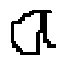

***************
Box: 
ymin:  0.41522804  xmin:  0.82342196  ymax:  0.5267494  xmax  0.9102618
left:  263.4950256347656  right:  291.2837791442871  top:  132.87297248840332  bottom  168.55979919433594
Top left point: ( 263 ,  132 ) and Bottom right point: ( 291 ,  168 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 73.34 %
Symbol_id: 0 , Latex: A , Confidence Score: 7.18 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 5.95 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 4.23 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.33 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.23 %


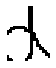

***************
Box: 
ymin:  0.43552032  xmin:  0.8101074  ymax:  0.5328576  xmax  0.8971216
left:  259.23437118530273  right:  287.078914642334  top:  139.36650276184082  bottom  170.51443099975586
Top left point: ( 259 ,  139 ) and Bottom right point: ( 287 ,  170 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 89.12 %
Symbol_id: 37 , Latex: a , Confidence Score: 7.53 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.26 %


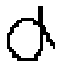

***************
Box: 
ymin:  0.44852424  xmin:  0.580608  ymax:  0.53704286  xmax  0.65205306
left:  185.79456329345703  right:  208.65697860717773  top:  143.5277557373047  bottom  171.8537139892578
Top left point: ( 185 ,  143 ) and Bottom right point: ( 208 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 38.5 %
Symbol_id: 39 , Latex: c , Confidence Score: 23.19 %
Symbol_id: 2 , Latex: C , Confidence Score: 11.39 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 7.83 %
Symbol_id: 41 , Latex: e , Confidence Score: 5.82 %
Symbol_id: 54 , Latex: r , Confidence Score: 4.4 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 3.49 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.18 %
Symbol_id: 11 , Latex: L , Confidence Score: 1.29 %


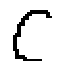

***************
Box: 
ymin:  0.4115512  xmin:  0.3845317  ymax:  0.5346085  xmax  0.44479075
left:  123.05014610290527  right:  142.33304023742676  top:  131.69638633728027  bottom  171.07471466064453
Top left point: ( 123 ,  131 ) and Bottom right point: ( 142 ,  171 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 57.53 %
Symbol_id: 47 , Latex: k , Confidence Score: 14.7 %
Symbol_id: 38 , Latex: b , Confidence Score: 11.27 %
Symbol_id: 44 , Latex: h , Confidence Score: 8.84 %
Symbol_id: 11 , Latex: L , Confidence Score: 2.71 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 2.49 %


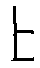

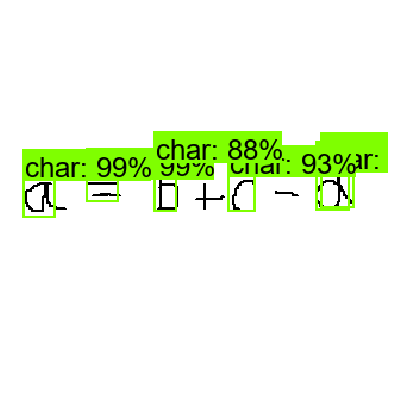

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0044.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.50612974  xmin:  0.27321777  ymax:  0.5793986  xmax  0.35144293
left:  87.42968559265137  right:  112.46173858642578  top:  161.96151733398438  bottom  185.40754318237305
Top left point: ( 87 ,  161 ) and Bottom right point: ( 112 ,  185 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 65.26 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 18.87 %
Symbol_id: 37 , Latex: a , Confidence Score: 8.81 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.06 %
Symbol_id: 16 , Latex: Q , Confidence Score: 1.0 %


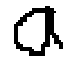

***************
Box: 
ymin:  0.5018033  xmin:  0.07283526  ymax:  0.59806925  xmax  0.15008509
left:  23.3072829246521  right:  48.02722930908203  top:  160.5770492553711  bottom  191.38216018676758
Top left point: ( 23 ,  160 ) and Bottom right point: ( 48 ,  191 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 10 , Latex: K , Confidence Score: 92.86 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.71 %


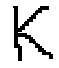

***************
Box: 
ymin:  0.49739337  xmin:  0.5085532  ymax:  0.59008604  xmax  0.595766
left:  162.7370262145996  right:  190.64512252807617  top:  159.16587829589844  bottom  188.82753372192383
Top left point: ( 162 ,  159 ) and Bottom right point: ( 190 ,  188 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 53.68 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 20.93 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 10.13 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 7.1 %
Symbol_id: 17 , Latex: R , Confidence Score: 1.36 %
Symbol_id: 6 , Latex: G , Confidence Score: 1.32 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.07 %


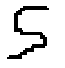

***************
Box: 
ymin:  0.50990945  xmin:  0.16916023  ymax:  0.56792194  xmax  0.25951123
left:  54.13127422332764  right:  83.04359436035156  top:  163.17102432250977  bottom  181.7350196838379
Top left point: ( 54 ,  163 ) and Bottom right point: ( 83 ,  181 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 65.93 %
Symbol_id: 17 , Latex: R , Confidence Score: 11.45 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 8.45 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.9 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.67 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 1.44 %
Symbol_id: 19 , Latex: T , Confidence Score: 1.21 %
Symbol_id: 5 , Latex: F , Confidence Score: 1.07 %


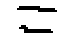

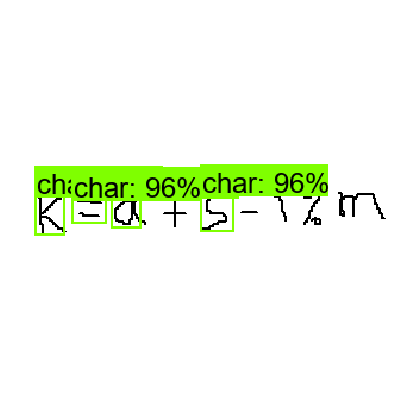

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0045.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.29410195  xmin:  0.19303487  ymax:  0.38296366  xmax  0.28569552
left:  61.771159172058105  right:  91.42256736755371  top:  94.11262512207031  bottom  122.54837036132812
Top left point: ( 61 ,  94 ) and Bottom right point: ( 91 ,  122 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 85.38 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 6.02 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 4.42 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.41 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.21 %


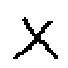

***************
Box: 
ymin:  0.30761084  xmin:  0.058331527  ymax:  0.39942813  xmax  0.15376447
left:  18.666088581085205  right:  49.204630851745605  top:  98.43546867370605  bottom  127.81700134277344
Top left point: ( 18 ,  98 ) and Bottom right point: ( 49 ,  127 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 26.76 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 19.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 13.94 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 11.65 %
Symbol_id: 79 , Latex: > , Confidence Score: 11.42 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.54 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.58 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 1.4 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.36 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.29 %


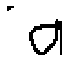

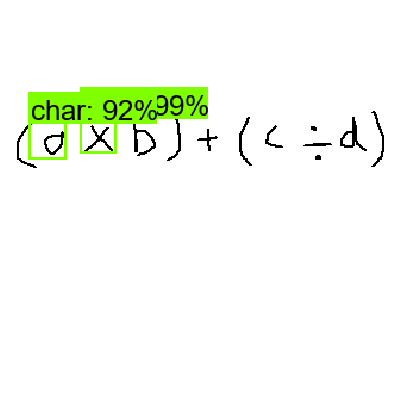

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0046.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.28593823  xmin:  0.6169029  ymax:  0.37703922  xmax  0.6929255
left:  197.4089241027832  right:  221.73616409301758  top:  91.50023460388184  bottom  120.65255165100098
Top left point: ( 197 ,  91 ) and Bottom right point: ( 221 ,  120 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 36.26 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 22.54 %
Symbol_id: 84 , Latex: + , Confidence Score: 12.92 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 7.39 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 6.36 %
Symbol_id: 89 , Latex: \# , Confidence Score: 5.98 %
Symbol_id: 47 , Latex: k , Confidence Score: 1.41 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.25 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.15 %


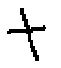

***************
Box: 
ymin:  0.30871597  xmin:  0.24082255  ymax:  0.3761069  xmax  0.32974148
left:  77.06321716308594  right:  105.51727294921875  top:  98.78911018371582  bottom  120.35420417785645
Top left point: ( 77 ,  98 ) and Bottom right point: ( 105 ,  120 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 57.03 %
Symbol_id: 40 , Latex: d , Confidence Score: 13.55 %
Symbol_id: 38 , Latex: b , Confidence Score: 12.05 %
Symbol_id: 46 , Latex: j , Confidence Score: 8.9 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 4.48 %


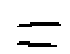

***************
Box: 
ymin:  0.2970291  xmin:  0.05488273  ymax:  0.42267618  xmax  0.13848959
left:  17.562474012374878  right:  44.31666851043701  top:  95.04931449890137  bottom  135.2563762664795
Top left point: ( 17 ,  95 ) and Bottom right point: ( 44 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 83.31 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 16.42 %


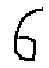

***************
Box: 
ymin:  0.28286526  xmin:  0.76595604  ymax:  0.3840607  xmax  0.85520333
left:  245.1059341430664  right:  273.66506576538086  top:  90.51688194274902  bottom  122.89942741394043
Top left point: ( 245 ,  90 ) and Bottom right point: ( 273 ,  122 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 49.21 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 34.92 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 11.11 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.14 %


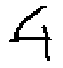

***************
Box: 
ymin:  0.25437224  xmin:  0.45502326  ymax:  0.32600817  xmax  0.53304774
left:  145.60744285583496  right:  170.57527542114258  top:  81.39911651611328  bottom  104.3226146697998
Top left point: ( 145 ,  81 ) and Bottom right point: ( 170 ,  104 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 30.59 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 19.94 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 9.81 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 6.68 %
Symbol_id: 0 , Latex: A , Confidence Score: 6.07 %
Symbol_id: 12 , Latex: M , Confidence Score: 5.19 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.67 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.93 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.91 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.7 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.59 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.44 %
Symbol_id: 88 , Latex: \& , Confidence Sc

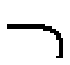

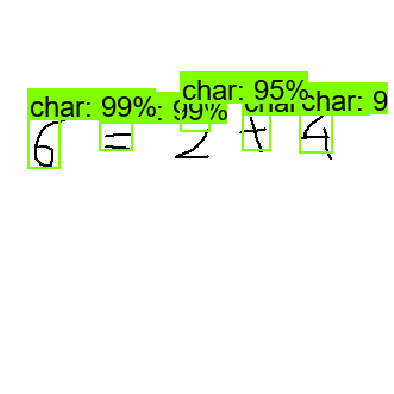

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0047.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.26994607  xmin:  0.084828965  ymax:  0.38040885  xmax  0.17364386
left:  27.14526891708374  right:  55.5660343170166  top:  86.38274192810059  bottom  121.73083305358887
Top left point: ( 27 ,  86 ) and Bottom right point: ( 55 ,  121 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 26 , Latex: 0 , Confidence Score: 55.87 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 10.68 %
Symbol_id: 14 , Latex: O , Confidence Score: 9.56 %
Symbol_id: 51 , Latex: o , Confidence Score: 7.92 %
Symbol_id: 2 , Latex: C , Confidence Score: 3.51 %
Symbol_id: 39 , Latex: c , Confidence Score: 2.77 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.6 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.51 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.04 %


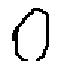

***************
Box: 
ymin:  0.24073525  xmin:  0.8285886  ymax:  0.36010623  xmax  0.93146795
left:  265.14835357666016  right:  298.0697441101074  top:  77.03527927398682  bottom  115.23399353027344
Top left point: ( 265 ,  77 ) and Bottom right point: ( 298 ,  115 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 25.36 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 23.4 %
Symbol_id: 53 , Latex: q , Confidence Score: 10.45 %
Symbol_id: 12 , Latex: M , Confidence Score: 7.92 %
Symbol_id: 7 , Latex: H , Confidence Score: 4.99 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 3.58 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.15 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 3.09 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.85 %
Symbol_id: 50 , Latex: n , Confidence Score: 2.64 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 1.78 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.43 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.1 %


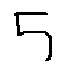

***************
Box: 
ymin:  0.24397877  xmin:  0.48729753  ymax:  0.36008632  xmax  0.5709972
left:  155.93521118164062  right:  182.71909713745117  top:  78.07320594787598  bottom  115.22762298583984
Top left point: ( 155 ,  78 ) and Bottom right point: ( 182 ,  115 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 27.17 %
Symbol_id: 92 , Latex: \times , Confidence Score: 26.98 %
Symbol_id: 90 , Latex: \% , Confidence Score: 10.15 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 8.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 5.36 %
Symbol_id: 0 , Latex: A , Confidence Score: 4.05 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.3 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.03 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.45 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.13 %
Symbol_id: 50 , Latex: n , Confidence Score: 1.09 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.06 %


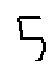

***************
Box: 
ymin:  0.2576996  xmin:  0.3912378  ymax:  0.37343442  xmax  0.45820737
left:  125.19609451293945  right:  146.62635803222656  top:  82.46387481689453  bottom  119.49901580810547
Top left point: ( 125 ,  82 ) and Bottom right point: ( 146 ,  119 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 81.05 %
Symbol_id: 79 , Latex: > , Confidence Score: 16.36 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.71 %


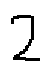

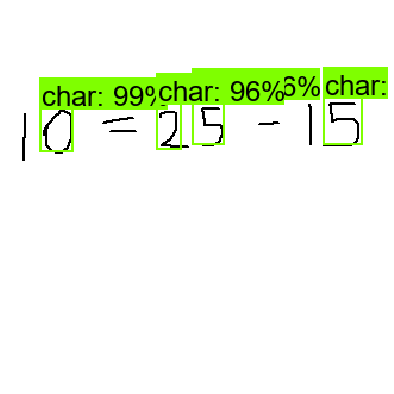

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0048.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.24487439  xmin:  0.82221013  ymax:  0.35440946  xmax  0.91807175
left:  263.1072425842285  right:  293.782958984375  top:  78.35980415344238  bottom  113.41102600097656
Top left point: ( 263 ,  78 ) and Bottom right point: ( 293 ,  113 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 34.38 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 17.69 %
Symbol_id: 13 , Latex: N , Confidence Score: 6.07 %
Symbol_id: 7 , Latex: H , Confidence Score: 5.38 %
Symbol_id: 44 , Latex: h , Confidence Score: 4.77 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.99 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.81 %
Symbol_id: 6 , Latex: G , Confidence Score: 1.79 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.71 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.36 %
Symbol_id: 55 , Latex: s , C

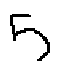

***************
Box: 
ymin:  0.23538123  xmin:  0.4679401  ymax:  0.34441742  xmax  0.56986874
left:  149.74082946777344  right:  182.3579978942871  top:  75.32199382781982  bottom  110.21357536315918
Top left point: ( 149 ,  75 ) and Bottom right point: ( 182 ,  110 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 12 , Latex: M , Confidence Score: 33.78 %
Symbol_id: 50 , Latex: n , Confidence Score: 21.59 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 8.14 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 7.38 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 4.61 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.29 %
Symbol_id: 49 , Latex: m , Confidence Score: 2.84 %
Symbol_id: 13 , Latex: N , Confidence Score: 2.05 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.46 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.28 %


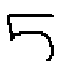

***************
Box: 
ymin:  0.2457726  xmin:  0.029882837  ymax:  0.36734125  xmax  0.11873423
left:  9.56250786781311  right:  37.99495458602905  top:  78.64723205566406  bottom  117.5492000579834
Top left point: ( 9 ,  78 ) and Bottom right point: ( 37 ,  117 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 77.61 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 10.38 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 5.2 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.67 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.63 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.12 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.06 %


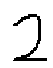

***************
Box: 
ymin:  0.27917507  xmin:  0.2967251  ymax:  0.3400122  xmax  0.386386
left:  94.95203018188477  right:  123.64352226257324  top:  89.33602333068848  bottom  108.80390167236328
Top left point: ( 94 ,  89 ) and Bottom right point: ( 123 ,  108 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 25.27 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 17.36 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 17.16 %
Symbol_id: 78 , Latex: < , Confidence Score: 7.74 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 7.44 %
Symbol_id: 60 , Latex: y , Confidence Score: 6.12 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 5.33 %
Symbol_id: 48 , Latex: l , Confidence Score: 2.82 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.03 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.79 %


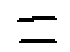

***************
Box: 
ymin:  0.2964552  xmin:  0.8244414  ymax:  0.36380798  xmax  0.9125315
left:  263.82123947143555  right:  292.0100784301758  top:  94.86566543579102  bottom  116.41855239868164
Top left point: ( 263 ,  94 ) and Bottom right point: ( 292 ,  116 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 9 , Latex: J , Confidence Score: 28.75 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 27.07 %
Symbol_id: 20 , Latex: U , Confidence Score: 20.5 %
Symbol_id: 100 , Latex: ] , Confidence Score: 7.31 %
Symbol_id: 21 , Latex: V , Confidence Score: 3.98 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.09 %
Symbol_id: 3 , Latex: D , Confidence Score: 1.94 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.87 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.76 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.17 %


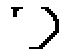

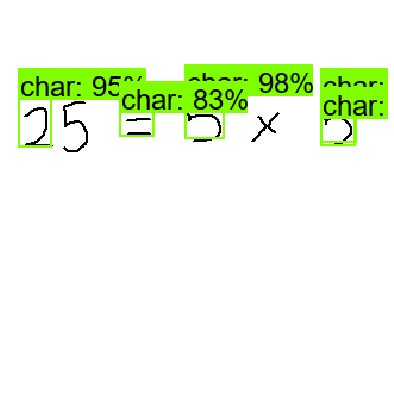

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0049.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.24410193  xmin:  0.6128091  ymax:  0.32217133  xmax  0.6886843
left:  196.09891891479492  right:  220.37897109985352  top:  78.11261653900146  bottom  103.0948257446289
Top left point: ( 196 ,  78 ) and Bottom right point: ( 220 ,  103 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 49.07 %
Symbol_id: 84 , Latex: + , Confidence Score: 15.18 %
Symbol_id: 47 , Latex: k , Confidence Score: 8.14 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 7.88 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 3.55 %
Symbol_id: 58 , Latex: w , Confidence Score: 3.11 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.0 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.34 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.26 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.21 %
Symbol_id: 76 , La

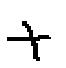

***************
Box: 
ymin:  0.2327427  xmin:  0.45788565  ymax:  0.32889628  xmax  0.53442365
left:  146.5234088897705  right:  171.01556777954102  top:  74.47766304016113  bottom  105.24681091308594
Top left point: ( 146 ,  74 ) and Bottom right point: ( 171 ,  105 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 64.18 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 20.61 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 5.06 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 3.34 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.15 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.86 %


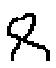

***************
Box: 
ymin:  0.2395706  xmin:  0.13211644  ymax:  0.35024965  xmax  0.23161387
left:  42.277259826660156  right:  74.11643981933594  top:  76.66259288787842  bottom  112.07988739013672
Top left point: ( 42 ,  76 ) and Bottom right point: ( 74 ,  112 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 65 , Latex: \Delta , Confidence Score: 44.38 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 20.28 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 8.48 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.33 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.98 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.37 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.9 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.75 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.74 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.2 %
Symbol_id: 48 , Latex: l , Confidence Score: 1.03 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.01 %


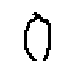

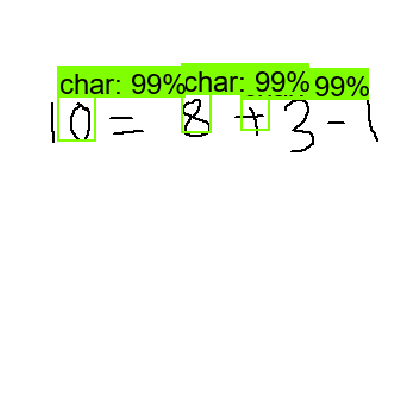

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0050.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.29101822  xmin:  0.24154268  ymax:  0.37782344  xmax  0.3085106
left:  77.29365825653076  right:  98.72339248657227  top:  93.12582969665527  bottom  120.90350151062012
Top left point: ( 77 ,  93 ) and Bottom right point: ( 98 ,  120 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 99.91 %


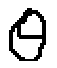

***************
Box: 
ymin:  0.2882424  xmin:  0.40381908  ymax:  0.3672599  xmax  0.45948717
left:  129.22210693359375  right:  147.0358943939209  top:  92.23756790161133  bottom  117.52316474914551
Top left point: ( 129 ,  92 ) and Bottom right point: ( 147 ,  117 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 53.4 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 33.96 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 7.07 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.43 %
Symbol_id: 40 , Latex: d , Confidence Score: 1.37 %


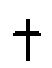

***************
Box: 
ymin:  0.25844374  xmin:  0.69514436  ymax:  0.36997485  xmax  0.79444915
left:  222.44619369506836  right:  254.22372817993164  top:  82.70199775695801  bottom  118.39195251464844
Top left point: ( 222 ,  82 ) and Bottom right point: ( 254 ,  118 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 65 , Latex: \Delta , Confidence Score: 55.01 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 14.14 %
Symbol_id: 7 , Latex: H , Confidence Score: 8.42 %
Symbol_id: 56 , Latex: u , Confidence Score: 4.72 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 4.13 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.75 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.45 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.24 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.17 %


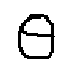

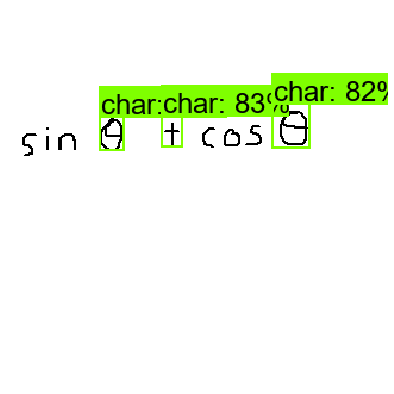

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0051.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.29632273  xmin:  0.2760508  ymax:  0.3459346  xmax  0.35486767
left:  88.33625793457031  right:  113.55765342712402  top:  94.82327461242676  bottom  110.69907188415527
Top left point: ( 88 ,  94 ) and Bottom right point: ( 113 ,  110 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 36 , Latex: \sigma , Confidence Score: 47.99 %
Symbol_id: 90 , Latex: \% , Confidence Score: 44.65 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.8 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.19 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.17 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.15 %


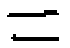

***************
Box: 
ymin:  0.28311527  xmin:  0.06128931  ymax:  0.3745643  xmax  0.14153068
left:  19.612579345703125  right:  45.28981685638428  top:  90.59688568115234  bottom  119.8605728149414
Top left point: ( 19 ,  90 ) and Bottom right point: ( 45 ,  119 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 90.9 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 4.65 %
Symbol_id: 53 , Latex: q , Confidence Score: 1.17 %


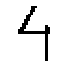

***************
Box: 
ymin:  0.23286669  xmin:  0.46969494  ymax:  0.36815545  xmax  0.57434076
left:  150.30238151550293  right:  183.78904342651367  top:  74.51734066009521  bottom  117.80974388122559
Top left point: ( 150 ,  74 ) and Bottom right point: ( 183 ,  117 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 62.67 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 18.88 %
Symbol_id: 79 , Latex: > , Confidence Score: 12.67 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.01 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.23 %


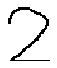

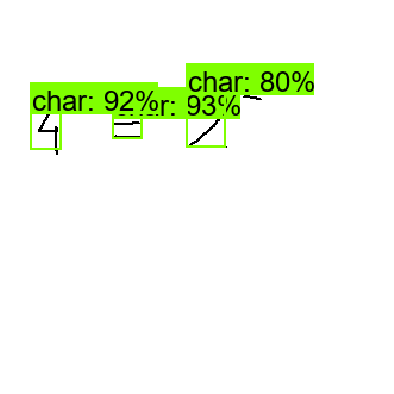

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0052.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.24383794  xmin:  0.4700751  ymax:  0.33230266  xmax  0.5408234
left:  150.4240322113037  right:  173.0634880065918  top:  78.0281400680542  bottom  106.33685111999512
Top left point: ( 150 ,  78 ) and Bottom right point: ( 173 ,  106 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 57.69 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 6.39 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 5.1 %
Symbol_id: 20 , Latex: U , Confidence Score: 4.66 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 3.6 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 3.3 %
Symbol_id: 56 , Latex: u , Confidence Score: 3.26 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.65 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.17 %
Symbol_id: 40 , Latex: 

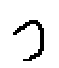

***************
Box: 
ymin:  0.24206471  xmin:  0.62659734  ymax:  0.35557094  xmax  0.71974945
left:  200.51115036010742  right:  230.31982421875  top:  77.46070861816406  bottom  113.78270149230957
Top left point: ( 200 ,  77 ) and Bottom right point: ( 230 ,  113 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 27.96 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 24.65 %
Symbol_id: 44 , Latex: h , Confidence Score: 7.79 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 5.19 %
Symbol_id: 59 , Latex: x , Confidence Score: 4.0 %
Symbol_id: 0 , Latex: A , Confidence Score: 3.56 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.46 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 3.44 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 2.28 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.13 %
Symbol_id: 40 , Latex: d , Confidence Score: 1.93 %
Symbol_id: 10 , Latex: K , Confidence Score: 1.93 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.21 %

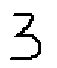

***************
Box: 
ymin:  0.22740975  xmin:  0.89666903  ymax:  0.3777456  xmax  0.9815346
left:  286.93408966064453  right:  314.09107208251953  top:  72.77112007141113  bottom  120.87859153747559
Top left point: ( 286 ,  72 ) and Bottom right point: ( 314 ,  120 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 101 , Latex: \| , Confidence Score: 70.37 %
Symbol_id: 48 , Latex: l , Confidence Score: 13.61 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.56 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.83 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.46 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.03 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.0 %


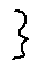

***************
Box: 
ymin:  0.24215277  xmin:  0.6351619  ymax:  0.32417354  xmax  0.69961387
left:  203.25180053710938  right:  223.87643814086914  top:  77.48888492584229  bottom  103.73553276062012
Top left point: ( 203 ,  77 ) and Bottom right point: ( 223 ,  103 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 48.15 %
Symbol_id: 92 , Latex: \times , Confidence Score: 16.98 %
Symbol_id: 59 , Latex: x , Confidence Score: 13.96 %
Symbol_id: 23 , Latex: X , Confidence Score: 6.36 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 3.45 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 3.26 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 3.19 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.57 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.15 %


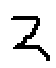

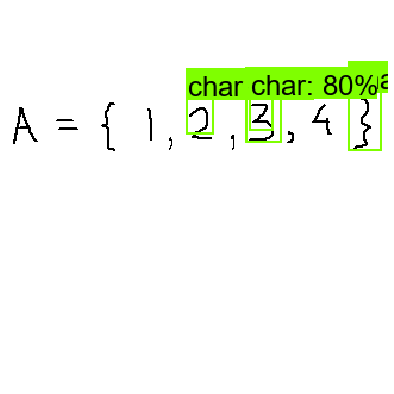

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0053.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.35300124  xmin:  0.23770328  ymax:  0.42222738  xmax  0.32437596
left:  76.06504917144775  right:  103.80030632019043  top:  112.96039581298828  bottom  135.11276245117188
Top left point: ( 76 ,  112 ) and Bottom right point: ( 103 ,  135 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 65 , Latex: \Delta , Confidence Score: 29.38 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 23.03 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 14.54 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.29 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.85 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 3.75 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 2.54 %
Symbol_id: 11 , Latex: L , Confidence Score: 2.02 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.97 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.61 %
Symbo

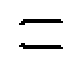

***************
Box: 
ymin:  0.34422046  xmin:  0.08585424  ymax:  0.45189324  xmax  0.16866608
left:  27.4733567237854  right:  53.973145484924316  top:  110.15054702758789  bottom  144.60583686828613
Top left point: ( 27 ,  110 ) and Bottom right point: ( 53 ,  144 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 72.18 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 15.36 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 6.98 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.46 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.2 %


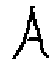

***************
Box: 
ymin:  0.3374693  xmin:  0.43832466  ymax:  0.43972832  xmax  0.5163309
left:  140.26389122009277  right:  165.22588729858398  top:  107.99017906188965  bottom  140.71306228637695
Top left point: ( 140 ,  107 ) and Bottom right point: ( 165 ,  140 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 94.98 %
Symbol_id: 11 , Latex: L , Confidence Score: 1.92 %


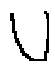

***************
Box: 
ymin:  0.34466034  xmin:  0.77381843  ymax:  0.43923888  xmax  0.85134184
left:  247.62189865112305  right:  272.4293899536133  top:  110.29130935668945  bottom  140.55644035339355
Top left point: ( 247 ,  110 ) and Bottom right point: ( 272 ,  140 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 22.36 %
Symbol_id: 11 , Latex: L , Confidence Score: 20.49 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 12.8 %
Symbol_id: 39 , Latex: c , Confidence Score: 8.85 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 7.63 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 5.44 %
Symbol_id: 2 , Latex: C , Confidence Score: 3.86 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 3.65 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.33 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.82 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.8 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.66 %
Symbol_id: 99 , Latex: [ , Confidence Score

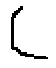

***************
Box: 
ymin:  0.32575798  xmin:  0.62102485  ymax:  0.43506536  xmax  0.6939806
left:  198.7279510498047  right:  222.07378387451172  top:  104.2425537109375  bottom  139.22091484069824
Top left point: ( 198 ,  104 ) and Bottom right point: ( 222 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 49.82 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 25.67 %
Symbol_id: 39 , Latex: c , Confidence Score: 14.47 %
Symbol_id: 41 , Latex: e , Confidence Score: 5.53 %
Symbol_id: 2 , Latex: C , Confidence Score: 3.01 %


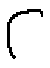

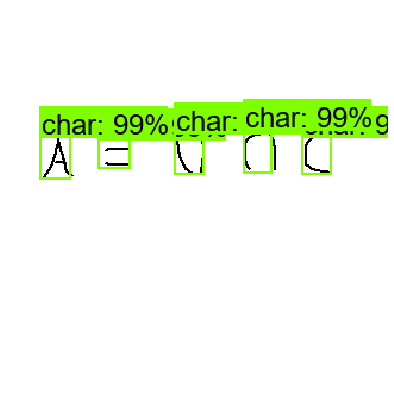

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test_images/exp0054.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3459448  xmin:  0.41061017  ymax:  0.4367101  xmax  0.4819846
left:  131.39525413513184  right:  154.2350673675537  top:  110.70233345031738  bottom  139.74722862243652
Top left point: ( 131 ,  110 ) and Bottom right point: ( 154 ,  139 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 64.06 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 26.06 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.5 %
Symbol_id: 0 , Latex: A , Confidence Score: 3.51 %


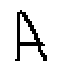

***************
Box: 
ymin:  0.34861588  xmin:  0.085388795  ymax:  0.46614978  xmax  0.16829833
left:  27.324414253234863  right:  53.85546684265137  top:  111.55708312988281  bottom  149.1679286956787
Top left point: ( 27 ,  111 ) and Bottom right point: ( 53 ,  149 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 72.58 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 11.77 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 8.89 %
Symbol_id: 0 , Latex: A , Confidence Score: 3.85 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.5 %


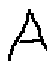

***************
Box: 
ymin:  0.3591804  xmin:  0.24068992  ymax:  0.426677  xmax  0.3173524
left:  77.02077388763428  right:  101.55277252197266  top:  114.93772506713867  bottom  136.53663635253906
Top left point: ( 77 ,  114 ) and Bottom right point: ( 101 ,  136 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 30.27 %
Symbol_id: 78 , Latex: < , Confidence Score: 21.15 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 11.44 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 9.27 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 6.87 %
Symbol_id: 48 , Latex: l , Confidence Score: 3.07 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.26 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.96 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.88 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.81 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.7 %
Symbol_id: 11 , Latex: L , Confidence Score: 1.2 %
Symbol_id: 77 , Latex: \geq , Confidence Score:

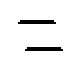

***************
Box: 
ymin:  0.34003502  xmin:  0.7491997  ymax:  0.43377742  xmax  0.83553123
left:  239.74390029907227  right:  267.3699951171875  top:  108.81120681762695  bottom  138.80877494812012
Top left point: ( 239 ,  108 ) and Bottom right point: ( 267 ,  138 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 70 , Latex: \mu , Confidence Score: 87.17 %
Symbol_id: 0 , Latex: A , Confidence Score: 5.58 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.94 %
Symbol_id: 13 , Latex: N , Confidence Score: 1.94 %
Symbol_id: 12 , Latex: M , Confidence Score: 1.13 %


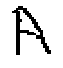

***************
Box: 
ymin:  0.33256948  xmin:  0.5775657  ymax:  0.4291722  xmax  0.654134
left:  184.8210334777832  right:  209.32287216186523  top:  106.42223358154297  bottom  137.3351001739502
Top left point: ( 184 ,  106 ) and Bottom right point: ( 209 ,  137 )
(1, 1024)
CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 48.05 %
Symbol_id: 11 , Latex: L , Confidence Score: 47.14 %


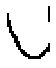

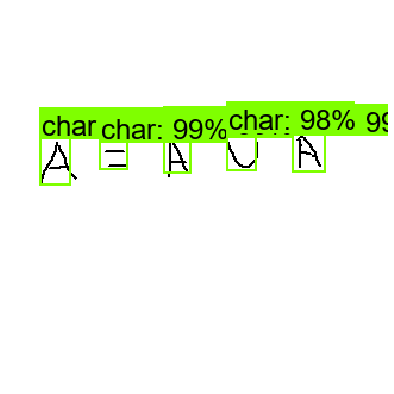

In [11]:
for image_path in TEST_IMAGE_PATHS:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    print('Image shape: ', image_np.shape)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # Visualization of the results of a detection.
    """
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    """
    # cv2.imshow('scene', image_np)
    # plt.show()

    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=2)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = c_im / 255.0
            # Symbol Prediction
            # CNN
            #c_im = np.resize(c_im, (1, 1, 32, 32))
            # res = cnn.predict(c_im)
            # ANN
            c_im = c_im.flatten().reshape((1, 32*32))
            print(c_im.shape)
            res = ann.predict(c_im)
            #
            res = res.flatten()
            # lbl = one_hot_encode_to_char(res, threshold=0.1)
            # if type(lbl) == list: lbl = lbl[0]
            # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN/ANN Predictions:")
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')
            plt.figure(figsize=(1,1))
            plt.axis('off')
            plt.imshow(np.asarray(cropped_image))
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
            #cv2.imshow('model', np.asarray(cropped_image))
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(cv2.resize(image_np, (int(im_width), int(im_height))))
    plt.show()
    #cv2.imshow(im_name, cv2.resize(image_np, (int(im_width), int(im_height))))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()


Character Segmentation Model

In [64]:
t_im

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.99607843, ..., 0.99607843, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 0.99607843, ..., 0.99607843, 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

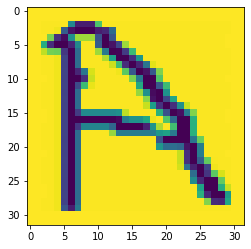

In [54]:
plt.imshow(t_im.reshape((32,32)))

In [73]:
t_im.shape

(1, 1, 32, 32)

In [44]:
def remove_wspaces(img_):
    gray_ = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    gray_ = 255*(gray_ < 128).astype(np.uint8) # To invert the text to white
    coords_ = cv2.findNonZero(gray_) # Find all non-zero points (text)
    x_, y_, w_, h_ = cv2.boundingRect(coords_) # Find minimum spanning bounding box
    rect_ = img_[y_:y_+h_, x_:x_+w_] # Crop the image - note we do this on the original image
    
    # add a white border of 1 pixel
    bordersize=2
    rect_ = cv2.copyMakeBorder(
        rect_,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    return rect_

Image path:  research/object_detection/training/test_images\exp0010.png


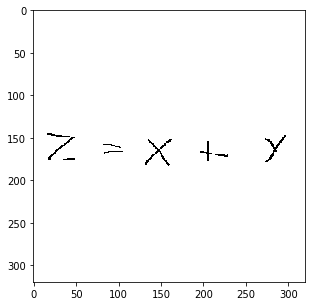

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


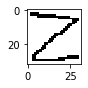

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


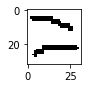

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 45.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 44.53 %
Symbol_id: 23 , Latex: X , Confidence Score: 8.99 %


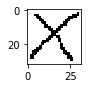

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 72.67 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 5.57 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 4.81 %
Symbol_id: 7 , Latex: H , Confidence Score: 4.22 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.94 %
Symbol_id: 44 , Latex: h , Confidence Score: 2.87 %
Symbol_id: 42 , Latex: f , Confidence Score: 2.32 %


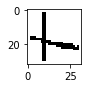

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 49.13 %
Symbol_id: 92 , Latex: \times , Confidence Score: 43.84 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.19 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.15 %


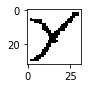

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0011.png


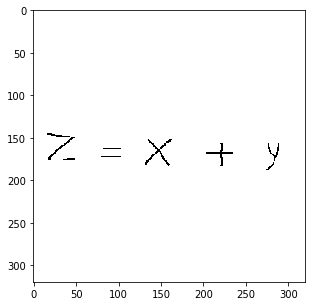

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


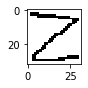

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


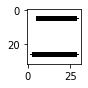

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 45.86 %
Symbol_id: 59 , Latex: x , Confidence Score: 44.53 %
Symbol_id: 23 , Latex: X , Confidence Score: 8.99 %


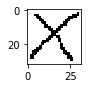

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 98.15 %


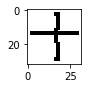

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


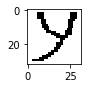

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0012.png


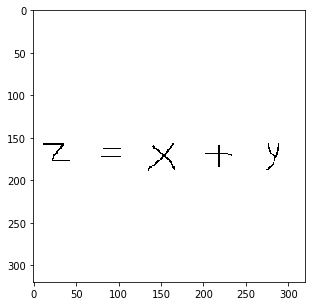

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


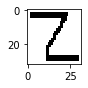

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


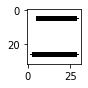

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.05 %
Symbol_id: 59 , Latex: x , Confidence Score: 25.44 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.82 %


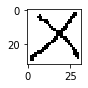

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 94.7 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.88 %


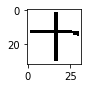

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


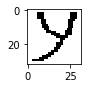

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0013.png


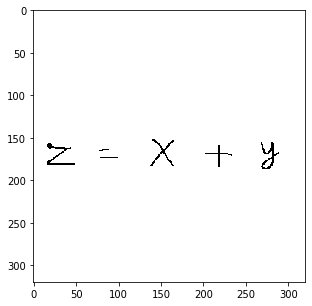

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 65.86 %
Symbol_id: 61 , Latex: z , Confidence Score: 27.23 %
Symbol_id: 25 , Latex: Z , Confidence Score: 4.97 %


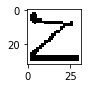

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 38.88 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 19.25 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 18.6 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.51 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.29 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.57 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.47 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.13 %


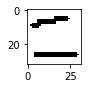

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 65.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 33.13 %


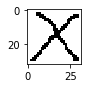

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 94.7 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.88 %


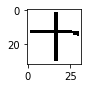

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 32.84 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 16.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.5 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.74 %
Symbol_id: 43 , Latex: g , Confidence Score: 4.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.71 %


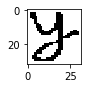

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0014.png


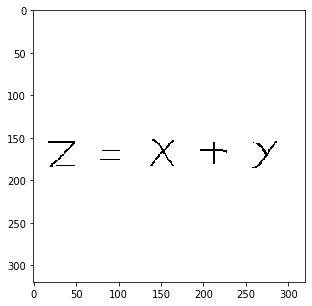

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.72 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.16 %


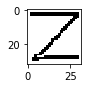

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


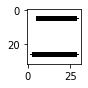

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 65.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 33.13 %


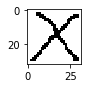

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 94.7 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.88 %


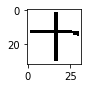

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 58.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 15.77 %
Symbol_id: 24 , Latex: Y , Confidence Score: 11.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.05 %


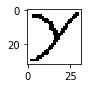

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0015.png


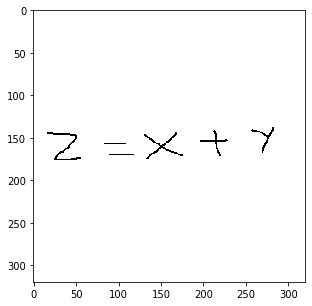

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 59.76 %
Symbol_id: 25 , Latex: Z , Confidence Score: 35.42 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 2.67 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.76 %


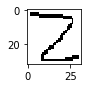

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 80.13 %
Symbol_id: 90 , Latex: \% , Confidence Score: 13.76 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.61 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.14 %


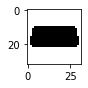

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 45.68 %
Symbol_id: 90 , Latex: \% , Confidence Score: 31.56 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 11.95 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 4.04 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.75 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.23 %


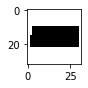

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 84.75 %
Symbol_id: 59 , Latex: x , Confidence Score: 12.76 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.39 %


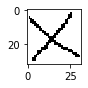

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 43.86 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 26.66 %
Symbol_id: 0 , Latex: A , Confidence Score: 7.44 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 7.26 %
Symbol_id: 7 , Latex: H , Confidence Score: 3.19 %
Symbol_id: 87 , Latex: \} , Confidence Score: 2.3 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.29 %
Symbol_id: 44 , Latex: h , Confidence Score: 2.27 %


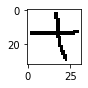

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 46.23 %
Symbol_id: 24 , Latex: Y , Confidence Score: 18.07 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 14.65 %
Symbol_id: 60 , Latex: y , Confidence Score: 14.39 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.28 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.1 %


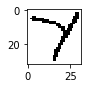

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0016.png


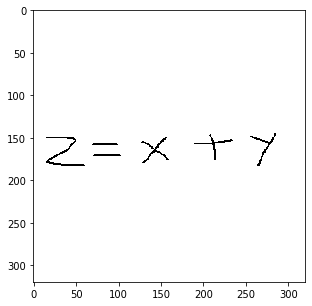

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 75.97 %
Symbol_id: 61 , Latex: z , Confidence Score: 16.93 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 4.38 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.26 %


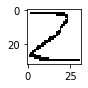

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 63.65 %
Symbol_id: 90 , Latex: \% , Confidence Score: 21.37 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 7.11 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.76 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.16 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.68 %


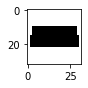

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 57.77 %
Symbol_id: 90 , Latex: \% , Confidence Score: 28.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 5.07 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.99 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 2.94 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.51 %


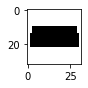

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 95.79 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.73 %


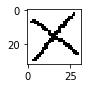

CNN/ANN Predictions:
Symbol_id: 19 , Latex: T , Confidence Score: 35.23 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 18.55 %
Symbol_id: 5 , Latex: F , Confidence Score: 14.14 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.19 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.33 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.06 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.33 %
Symbol_id: 84 , Latex: + , Confidence Score: 2.23 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.95 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 1.53 %
Symbol_id: 42 , Latex: f , Confidence Score: 1.3 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.2 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.05 %


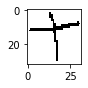

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 63.42 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 18.66 %
Symbol_id: 24 , Latex: Y , Confidence Score: 8.49 %
Symbol_id: 60 , Latex: y , Confidence Score: 3.73 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.2 %


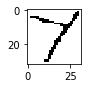

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0017.png


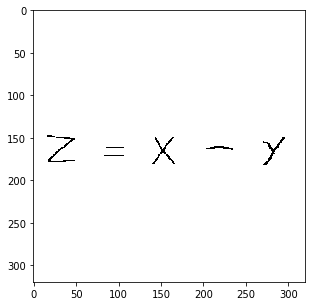

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


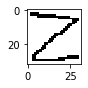

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


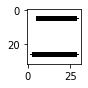

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 88.36 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.17 %


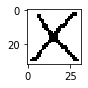

CNN/ANN Predictions:
Symbol_id: 70 , Latex: \mu , Confidence Score: 94.39 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.92 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.3 %


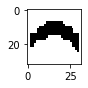

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 49.13 %
Symbol_id: 92 , Latex: \times , Confidence Score: 43.84 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.19 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.15 %


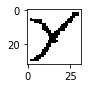

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0018.png


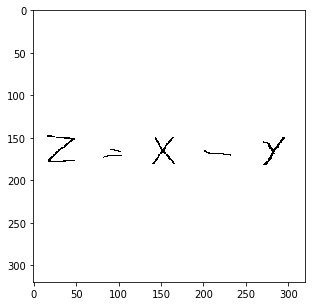

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


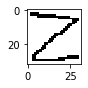

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


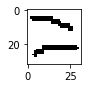

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 88.36 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.17 %


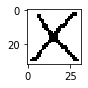

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 40.75 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 32.88 %
Symbol_id: 90 , Latex: \% , Confidence Score: 16.22 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 5.32 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 3.61 %


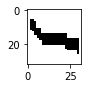

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 49.13 %
Symbol_id: 92 , Latex: \times , Confidence Score: 43.84 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.19 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.15 %


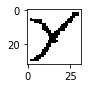

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0019.png


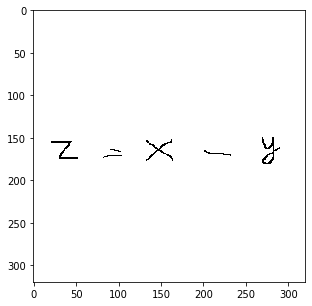

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


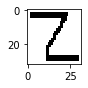

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


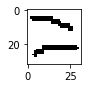

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


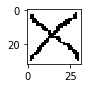

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 40.75 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 32.88 %
Symbol_id: 90 , Latex: \% , Confidence Score: 16.22 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 5.32 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 3.61 %


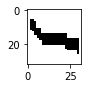

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 32.84 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 16.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.5 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.74 %
Symbol_id: 43 , Latex: g , Confidence Score: 4.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.71 %


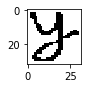

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0020.png


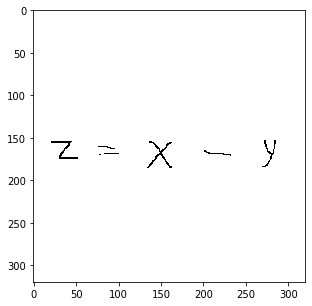

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


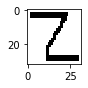

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


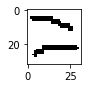

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 65.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 33.13 %


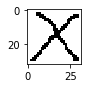

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 40.75 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 32.88 %
Symbol_id: 90 , Latex: \% , Confidence Score: 16.22 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 5.32 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 3.61 %


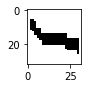

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


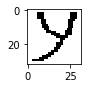

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0021.png


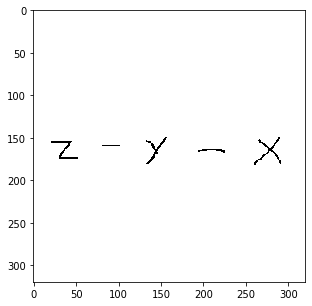

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


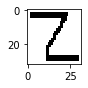

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


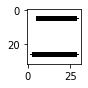

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 49.13 %
Symbol_id: 92 , Latex: \times , Confidence Score: 43.84 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.19 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.15 %


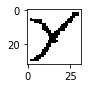

CNN/ANN Predictions:
Symbol_id: 70 , Latex: \mu , Confidence Score: 94.39 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.92 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.3 %


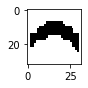

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.05 %
Symbol_id: 59 , Latex: x , Confidence Score: 25.44 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.82 %


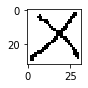

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0022.png


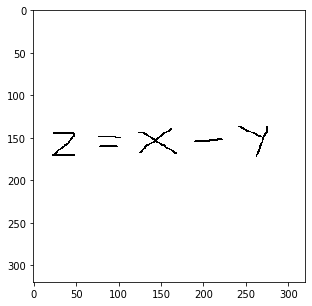

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 83.88 %
Symbol_id: 61 , Latex: z , Confidence Score: 15.13 %


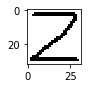

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 69.6 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 8.21 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.52 %
Symbol_id: 25 , Latex: Z , Confidence Score: 4.0 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.45 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.92 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.69 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.65 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.01 %


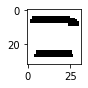

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 78.34 %
Symbol_id: 59 , Latex: x , Confidence Score: 20.02 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.44 %


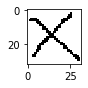

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 92.18 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %


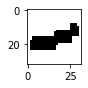

CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 45.83 %
Symbol_id: 79 , Latex: > , Confidence Score: 13.72 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.63 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.81 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.74 %
Symbol_id: 87 , Latex: \} , Confidence Score: 2.66 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.52 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.79 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.75 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.67 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.55 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.44 %
Symbol_id: 51 , Latex: o , Confidence Score: 1.27 %


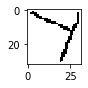

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0023.png


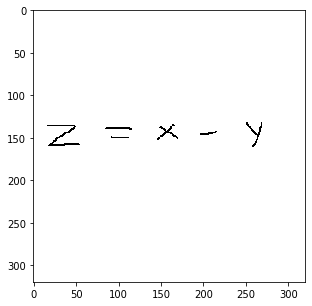

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 66.44 %
Symbol_id: 25 , Latex: Z , Confidence Score: 31.0 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.46 %


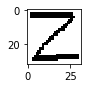

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 43.22 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 10.83 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.1 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.67 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 6.28 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.53 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.94 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.77 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.56 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.03 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 1.97 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.72 %


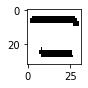

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.08 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.85 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.52 %


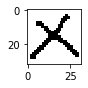

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 99.0 %


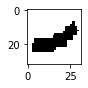

CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 45.56 %
Symbol_id: 60 , Latex: y , Confidence Score: 38.27 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.45 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.77 %


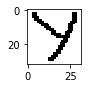

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0024.png


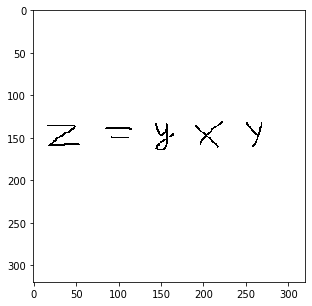

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 66.44 %
Symbol_id: 25 , Latex: Z , Confidence Score: 31.0 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.46 %


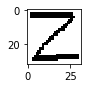

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 43.22 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 10.83 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.1 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.67 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 6.28 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.53 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.94 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.77 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.56 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.03 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 1.97 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.72 %


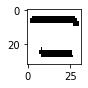

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 32.84 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 16.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.5 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.74 %
Symbol_id: 43 , Latex: g , Confidence Score: 4.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.71 %


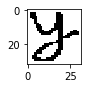

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.41 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.28 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.15 %


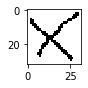

CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 45.56 %
Symbol_id: 60 , Latex: y , Confidence Score: 38.27 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.45 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.77 %


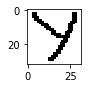

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0025.png


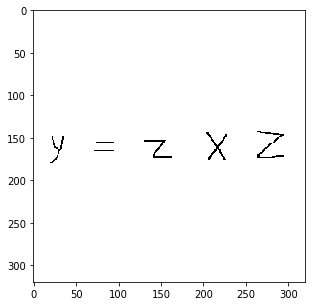

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


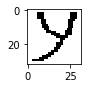

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


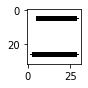

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


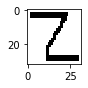

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.45 %


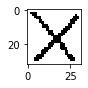

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


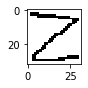

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0026.png


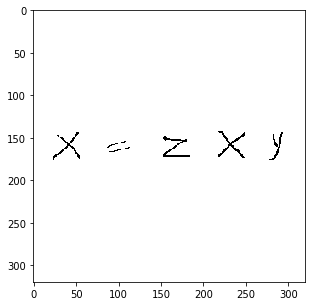

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.05 %
Symbol_id: 59 , Latex: x , Confidence Score: 25.44 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.82 %


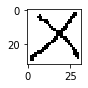

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 56.23 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 17.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 9.32 %
Symbol_id: 94 , Latex: \div , Confidence Score: 5.37 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 2.12 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.41 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 1.29 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.01 %


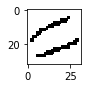

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 65.86 %
Symbol_id: 61 , Latex: z , Confidence Score: 27.23 %
Symbol_id: 25 , Latex: Z , Confidence Score: 4.97 %


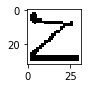

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 93.63 %
Symbol_id: 59 , Latex: x , Confidence Score: 5.49 %


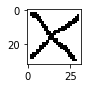

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 85.72 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.73 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 5.76 %


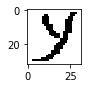

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0027.png


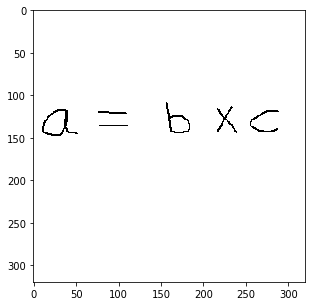

CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 79.14 %
Symbol_id: 16 , Latex: Q , Confidence Score: 5.84 %
Symbol_id: 88 , Latex: \& , Confidence Score: 3.02 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.35 %
Symbol_id: 40 , Latex: d , Confidence Score: 2.24 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.07 %


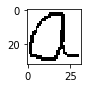

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 79.45 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 10.38 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.43 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.39 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.02 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.47 %


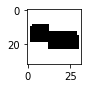

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 46.4 %
Symbol_id: 90 , Latex: \% , Confidence Score: 43.08 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 4.3 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.91 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.54 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.47 %


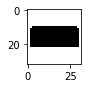

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 92.06 %
Symbol_id: 1 , Latex: B , Confidence Score: 2.23 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.46 %


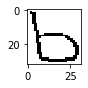

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 79.64 %
Symbol_id: 59 , Latex: x , Confidence Score: 12.67 %
Symbol_id: 23 , Latex: X , Confidence Score: 5.86 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.7 %


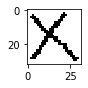

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 61.28 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 23.54 %
Symbol_id: 39 , Latex: c , Confidence Score: 7.42 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.69 %
Symbol_id: 2 , Latex: C , Confidence Score: 1.43 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 1.42 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.29 %


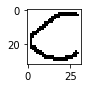

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0028.png


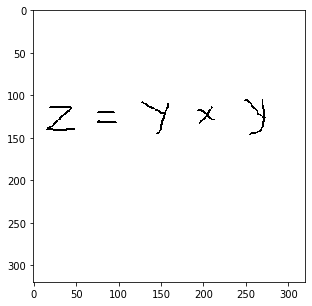

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 84.41 %
Symbol_id: 61 , Latex: z , Confidence Score: 14.62 %


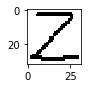

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 96.86 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.07 %


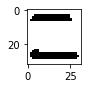

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 45.25 %
Symbol_id: 24 , Latex: Y , Confidence Score: 23.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 15.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.06 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.51 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.47 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.44 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.04 %


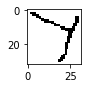

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 63.87 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 29.45 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.34 %


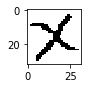

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 38.97 %
Symbol_id: 79 , Latex: > , Confidence Score: 14.67 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.09 %
Symbol_id: 87 , Latex: \} , Confidence Score: 9.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 6.76 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.76 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 2.85 %
Symbol_id: 3 , Latex: D , Confidence Score: 2.46 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.15 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 2.11 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.56 %


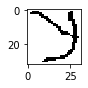

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0029.png


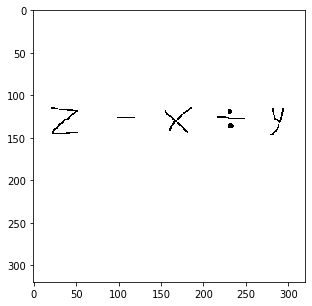

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


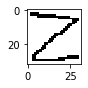

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


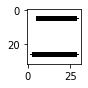

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.41 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.28 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.15 %


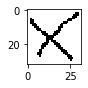

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.02 %


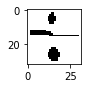

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


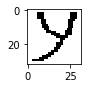

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0030.png


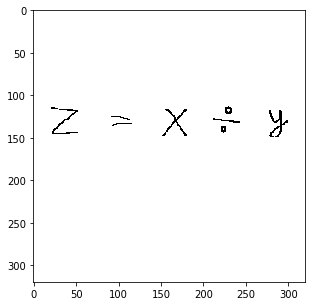

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


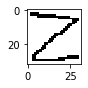

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


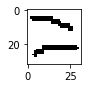

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 65.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 33.13 %


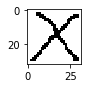

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 98.57 %


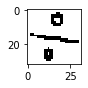

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 32.84 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 16.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.5 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.74 %
Symbol_id: 43 , Latex: g , Confidence Score: 4.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.71 %


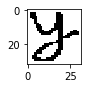

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0031.png


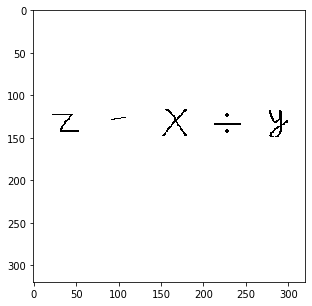

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


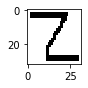

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 38.88 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 19.25 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 18.6 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.51 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.29 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.57 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.47 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.13 %


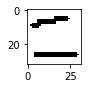

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 65.58 %
Symbol_id: 59 , Latex: x , Confidence Score: 33.13 %


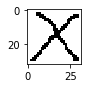

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.79 %


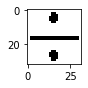

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 32.84 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 16.74 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.5 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.26 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.74 %
Symbol_id: 43 , Latex: g , Confidence Score: 4.5 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.75 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.71 %


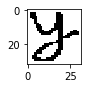

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0032.png


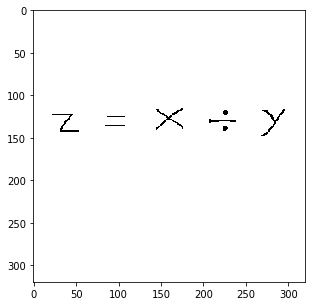

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 63.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 33.58 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.16 %


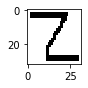

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


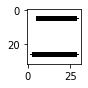

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


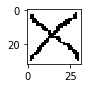

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 98.26 %


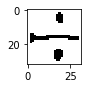

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 58.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 15.77 %
Symbol_id: 24 , Latex: Y , Confidence Score: 11.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.05 %


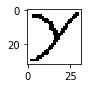

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0033.png


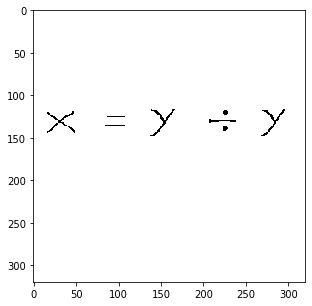

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


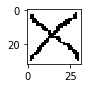

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


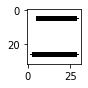

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 58.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 15.77 %
Symbol_id: 24 , Latex: Y , Confidence Score: 11.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.05 %


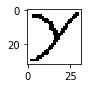

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 98.26 %


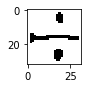

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 58.33 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 15.77 %
Symbol_id: 24 , Latex: Y , Confidence Score: 11.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.05 %


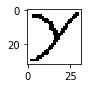

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0034.png


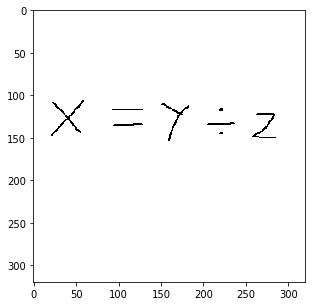

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.47 %
Symbol_id: 59 , Latex: x , Confidence Score: 8.3 %


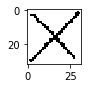

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 46.4 %
Symbol_id: 90 , Latex: \% , Confidence Score: 43.08 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 4.3 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.91 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.54 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.47 %


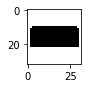

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 95.0 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.16 %


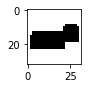

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 73.42 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.34 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.75 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.16 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.08 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.7 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.4 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.3 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.28 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.14 %


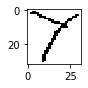

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 29.26 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 13.99 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 10.63 %
Symbol_id: 19 , Latex: T , Confidence Score: 8.67 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.15 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 6.01 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.41 %
Symbol_id: 5 , Latex: F , Confidence Score: 3.19 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.1 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.97 %
Symbol_id: 9 , Latex: J , Confidence Score: 1.82 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.03 %


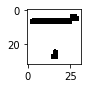

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 99.87 %


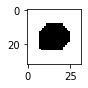

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 84.71 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.3 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.33 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.53 %


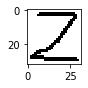

number of char in image: 7
Image path:  research/object_detection/training/test_images\exp0035.png


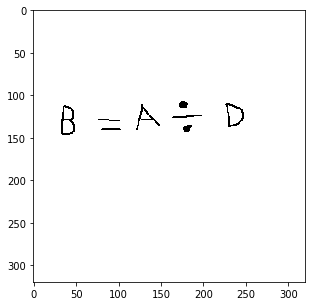

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 62.29 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 24.95 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.91 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.91 %
Symbol_id: 1 , Latex: B , Confidence Score: 1.91 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.59 %


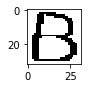

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 81.59 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.09 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.71 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.5 %


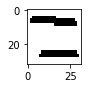

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 99.42 %


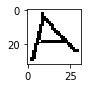

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.57 %


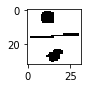

CNN/ANN Predictions:
Symbol_id: 3 , Latex: D , Confidence Score: 91.42 %
Symbol_id: 1 , Latex: B , Confidence Score: 3.62 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.28 %


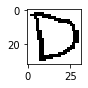

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0036.png


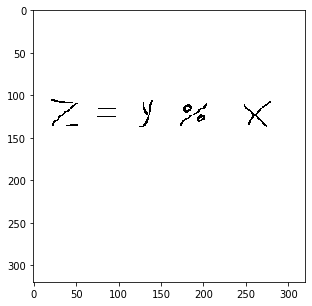

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 74.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 25.58 %


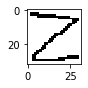

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


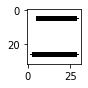

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 85.72 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.73 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 5.76 %


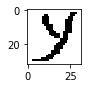

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.99 %


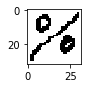

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.41 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.28 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.15 %


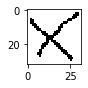

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0037.png


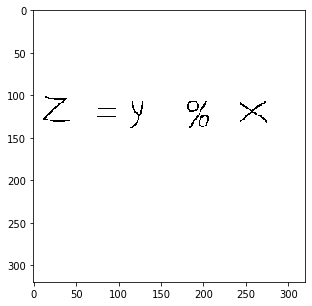

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 79.57 %
Symbol_id: 25 , Latex: Z , Confidence Score: 15.29 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.19 %


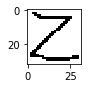

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


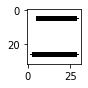

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


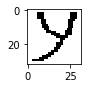

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.9 %


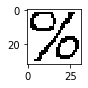

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


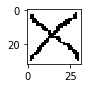

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0038.png


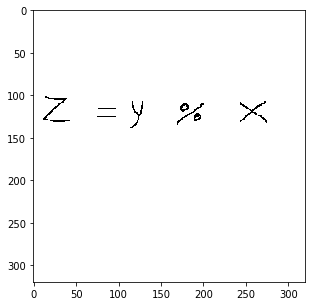

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 79.57 %
Symbol_id: 25 , Latex: Z , Confidence Score: 15.29 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.19 %


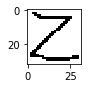

CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 24.79 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 23.84 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 8.15 %
Symbol_id: 25 , Latex: Z , Confidence Score: 7.1 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 4.66 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.39 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.62 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.17 %
Symbol_id: 100 , Latex: ] , Confidence Score: 2.63 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.49 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.94 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.9 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.44 %


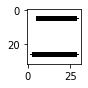

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


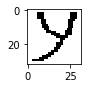

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.99 %


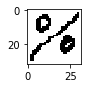

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


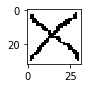

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0039.png


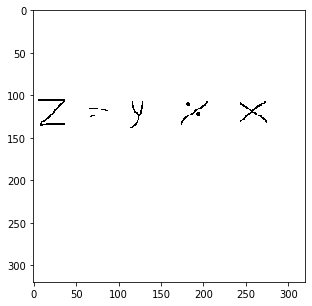

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.72 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.16 %


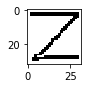

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.74 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.52 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.52 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.29 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.77 %


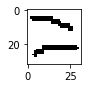

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


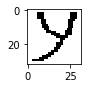

CNN/ANN Predictions:
Symbol_id: 59 , Latex: x , Confidence Score: 40.23 %
Symbol_id: 90 , Latex: \% , Confidence Score: 30.85 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 6.99 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.62 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.31 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.2 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.95 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.38 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.36 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.18 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.09 %


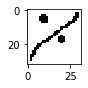

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


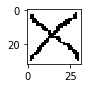

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0040.png


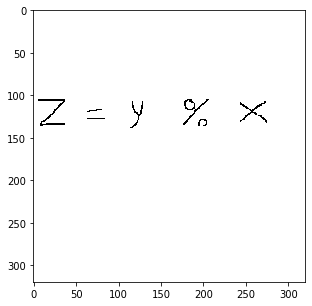

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.72 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.16 %


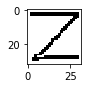

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 38.88 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 19.25 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 18.6 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.24 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.51 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.29 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.57 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.47 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.13 %


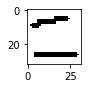

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 90.89 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.05 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.3 %


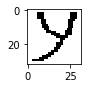

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.97 %


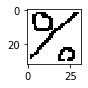

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 50.76 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 40.58 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 6.14 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.08 %


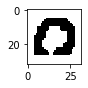

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 92.25 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.35 %


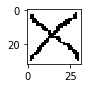

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0041.png


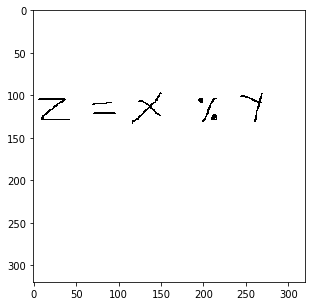

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 88.1 %
Symbol_id: 61 , Latex: z , Confidence Score: 11.62 %


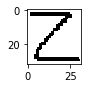

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 46.18 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 16.6 %
Symbol_id: 61 , Latex: z , Confidence Score: 15.87 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 12.7 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.95 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.91 %


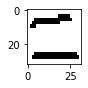

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 72.49 %
Symbol_id: 59 , Latex: x , Confidence Score: 26.31 %


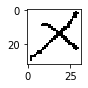

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.84 %


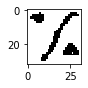

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 26.1 %
Symbol_id: 24 , Latex: Y , Confidence Score: 20.16 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 13.49 %
Symbol_id: 60 , Latex: y , Confidence Score: 9.95 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 7.7 %
Symbol_id: 87 , Latex: \} , Confidence Score: 3.35 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 2.88 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.62 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.57 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.41 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 1.23 %


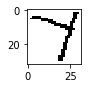

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0042.png


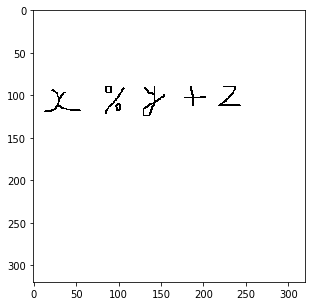

CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 52.48 %
Symbol_id: 47 , Latex: k , Confidence Score: 14.03 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 8.43 %
Symbol_id: 59 , Latex: x , Confidence Score: 4.56 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.81 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 3.79 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.51 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 2.39 %
Symbol_id: 10 , Latex: K , Confidence Score: 1.21 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.08 %


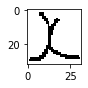

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.98 %


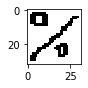

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 51.93 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 17.64 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 14.21 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.49 %
Symbol_id: 88 , Latex: \& , Confidence Score: 5.34 %


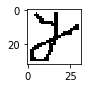

CNN/ANN Predictions:
Symbol_id: 89 , Latex: \# , Confidence Score: 36.59 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 32.51 %
Symbol_id: 84 , Latex: + , Confidence Score: 26.05 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.62 %


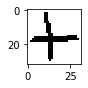

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 71.34 %
Symbol_id: 25 , Latex: Z , Confidence Score: 16.53 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 10.49 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.39 %


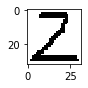

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0043.png


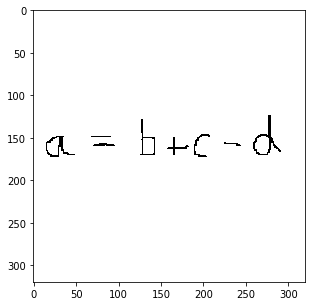

CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 53.41 %
Symbol_id: 88 , Latex: \& , Confidence Score: 23.23 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 9.01 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 6.55 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.95 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.4 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.33 %


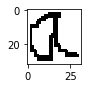

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 71.56 %
Symbol_id: 61 , Latex: z , Confidence Score: 8.55 %
Symbol_id: 94 , Latex: \div , Confidence Score: 5.53 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.31 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.31 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.19 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.09 %


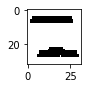

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 89.02 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 3.52 %
Symbol_id: 1 , Latex: B , Confidence Score: 2.03 %
Symbol_id: 44 , Latex: h , Confidence Score: 1.24 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.0 %


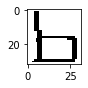

CNN/ANN Predictions:
Symbol_id: 78 , Latex: < , Confidence Score: 23.05 %
Symbol_id: 90 , Latex: \% , Confidence Score: 21.94 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 16.6 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 13.1 %
Symbol_id: 59 , Latex: x , Confidence Score: 10.58 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.25 %


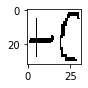

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 76.35 %
Symbol_id: 90 , Latex: \% , Confidence Score: 19.28 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.87 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.06 %


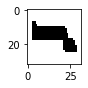

CNN/ANN Predictions:
Symbol_id: 40 , Latex: d , Confidence Score: 98.14 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.41 %


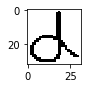

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0044.png


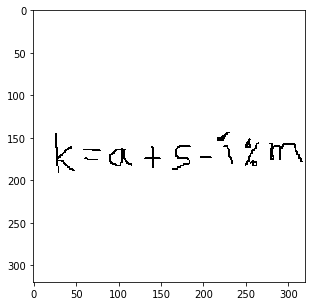

CNN/ANN Predictions:
Symbol_id: 47 , Latex: k , Confidence Score: 61.2 %
Symbol_id: 88 , Latex: \& , Confidence Score: 17.68 %
Symbol_id: 10 , Latex: K , Confidence Score: 10.5 %
Symbol_id: 17 , Latex: R , Confidence Score: 9.36 %


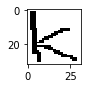

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 60.94 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 20.69 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.97 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.57 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.18 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.67 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.35 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.12 %


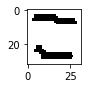

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 48.78 %
Symbol_id: 37 , Latex: a , Confidence Score: 42.01 %
Symbol_id: 16 , Latex: Q , Confidence Score: 4.2 %
Symbol_id: 40 , Latex: d , Confidence Score: 2.71 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 1.08 %


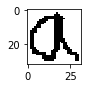

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 98.08 %


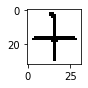

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 61.06 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 19.71 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 8.53 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.59 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 3.16 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.49 %


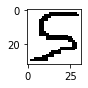

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 98.47 %


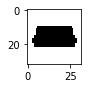

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 30.08 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 23.02 %
Symbol_id: 90 , Latex: \% , Confidence Score: 19.19 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 9.62 %
Symbol_id: 92 , Latex: \times , Confidence Score: 6.02 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.63 %
Symbol_id: 17 , Latex: R , Confidence Score: 1.61 %
Symbol_id: 53 , Latex: q , Confidence Score: 1.53 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.19 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.15 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.08 %


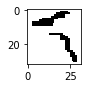

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 95.88 %
Symbol_id: 88 , Latex: \& , Confidence Score: 3.01 %


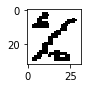

CNN/ANN Predictions:
Symbol_id: 50 , Latex: n , Confidence Score: 60.43 %
Symbol_id: 49 , Latex: m , Confidence Score: 19.84 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 10.29 %
Symbol_id: 7 , Latex: H , Confidence Score: 3.01 %
Symbol_id: 101 , Latex: \| , Confidence Score: 2.63 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.48 %


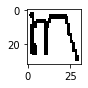

number of char in image: 9
Image path:  research/object_detection/training/test_images\exp0045.png


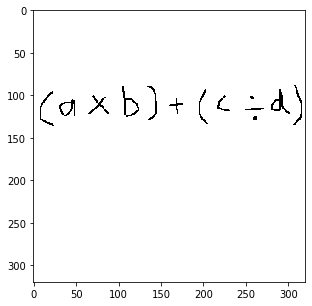

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 37.83 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 21.14 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 13.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 8.6 %
Symbol_id: 39 , Latex: c , Confidence Score: 7.07 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.96 %
Symbol_id: 78 , Latex: < , Confidence Score: 2.57 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.37 %
Symbol_id: 45 , Latex: i , Confidence Score: 1.23 %


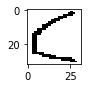

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 55.4 %
Symbol_id: 37 , Latex: a , Confidence Score: 24.8 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 18.89 %


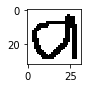

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 72.55 %
Symbol_id: 59 , Latex: x , Confidence Score: 17.25 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 7.37 %
Symbol_id: 23 , Latex: X , Confidence Score: 2.4 %


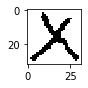

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 97.9 %
Symbol_id: 1 , Latex: B , Confidence Score: 1.27 %


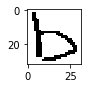

CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 65.55 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 14.11 %
Symbol_id: 60 , Latex: y , Confidence Score: 3.63 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 2.41 %
Symbol_id: 87 , Latex: \} , Confidence Score: 2.23 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.96 %
Symbol_id: 1 , Latex: B , Confidence Score: 1.69 %
Symbol_id: 3 , Latex: D , Confidence Score: 1.49 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.41 %


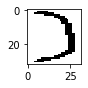

CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 58.53 %
Symbol_id: 84 , Latex: + , Confidence Score: 18.67 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 7.57 %
Symbol_id: 89 , Latex: \# , Confidence Score: 7.27 %
Symbol_id: 42 , Latex: f , Confidence Score: 2.26 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.02 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.52 %


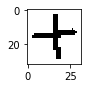

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 91.4 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 7.03 %


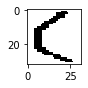

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 85.52 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 6.29 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 3.37 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 2.27 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.4 %


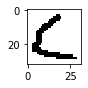

CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 60.05 %
Symbol_id: 0 , Latex: A , Confidence Score: 6.82 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 6.07 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.85 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 4.53 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 4.38 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.09 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.75 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.67 %
Symbol_id: 44 , Latex: h , Confidence Score: 1.42 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.28 %


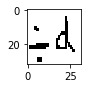

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 37.64 %
Symbol_id: 87 , Latex: \} , Confidence Score: 16.45 %
Symbol_id: 60 , Latex: y , Confidence Score: 15.19 %
Symbol_id: 79 , Latex: > , Confidence Score: 7.65 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 7.32 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.38 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.79 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 1.55 %
Symbol_id: 3 , Latex: D , Confidence Score: 1.31 %
Symbol_id: 9 , Latex: J , Confidence Score: 1.17 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.15 %


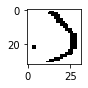

number of char in image: 10
Image path:  research/object_detection/training/test_images\exp0046.png


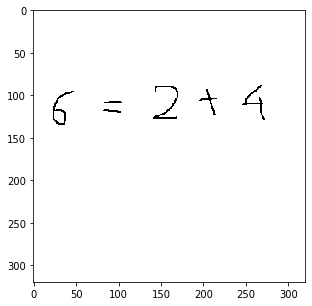

CNN/ANN Predictions:
Symbol_id: 32 , Latex: 6 , Confidence Score: 96.25 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 2.61 %


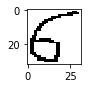

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 67.68 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 20.47 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.5 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.42 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.38 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.01 %


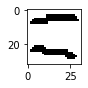

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 99.68 %


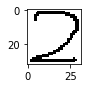

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 73.92 %
Symbol_id: 0 , Latex: A , Confidence Score: 10.94 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.74 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.64 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.37 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.31 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.2 %


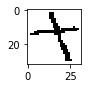

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 45.52 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 29.21 %
Symbol_id: 6 , Latex: G , Confidence Score: 11.71 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 5.07 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.08 %


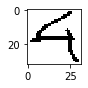

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0047.png


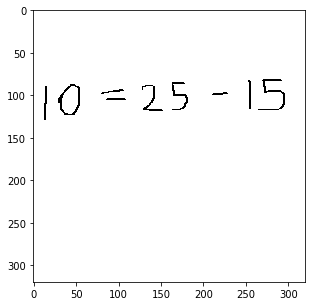

CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 97.15 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.41 %


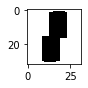

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 37.68 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 19.36 %
Symbol_id: 14 , Latex: O , Confidence Score: 17.37 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 9.91 %
Symbol_id: 51 , Latex: o , Confidence Score: 8.95 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 1.82 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.05 %


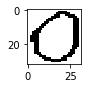

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 43.02 %
Symbol_id: 61 , Latex: z , Confidence Score: 24.81 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 17.98 %
Symbol_id: 25 , Latex: Z , Confidence Score: 5.78 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.44 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.03 %


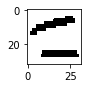

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 99.04 %


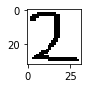

CNN/ANN Predictions:
Symbol_id: 31 , Latex: 5 , Confidence Score: 51.76 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 40.9 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 4.07 %


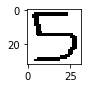

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 99.31 %


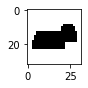

CNN/ANN Predictions:
Symbol_id: 99 , Latex: [ , Confidence Score: 54.63 %
Symbol_id: 55 , Latex: s , Confidence Score: 22.18 %
Symbol_id: 18 , Latex: S , Confidence Score: 10.95 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 5.51 %


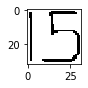

number of char in image: 7
Image path:  research/object_detection/training/test_images\exp0048.png


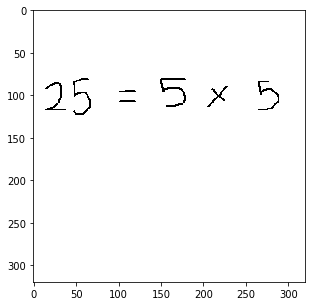

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 22.48 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 20.27 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 13.62 %
Symbol_id: 9 , Latex: J , Confidence Score: 11.79 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 8.73 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.89 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.79 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.05 %
Symbol_id: 18 , Latex: S , Confidence Score: 2.26 %
Symbol_id: 55 , Latex: s , Confidence Score: 1.42 %


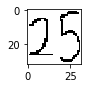

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 89.01 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.66 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.11 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.16 %


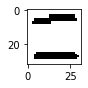

CNN/ANN Predictions:
Symbol_id: 31 , Latex: 5 , Confidence Score: 87.24 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 7.75 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.66 %


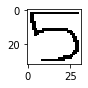

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 95.61 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.23 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.11 %


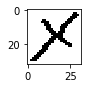

CNN/ANN Predictions:
Symbol_id: 31 , Latex: 5 , Confidence Score: 81.63 %
Symbol_id: 1 , Latex: B , Confidence Score: 5.87 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 2.84 %
Symbol_id: 87 , Latex: \} , Confidence Score: 2.27 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.71 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.4 %


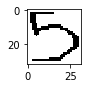

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0049.png


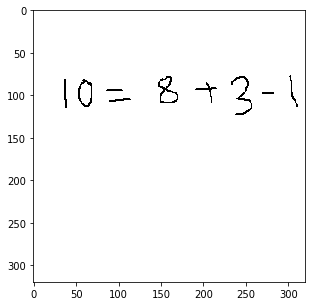

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 50.27 %
Symbol_id: 88 , Latex: \& , Confidence Score: 29.72 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 11.46 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.11 %
Symbol_id: 47 , Latex: k , Confidence Score: 2.53 %


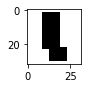

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 96.43 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.86 %


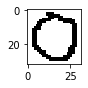

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 73.11 %
Symbol_id: 61 , Latex: z , Confidence Score: 9.69 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 4.17 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.61 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.76 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.1 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.53 %


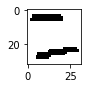

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 79.91 %
Symbol_id: 34 , Latex: 8 , Confidence Score: 15.85 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.16 %


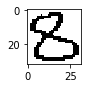

CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 95.47 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.08 %


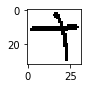

CNN/ANN Predictions:
Symbol_id: 29 , Latex: 3 , Confidence Score: 99.56 %


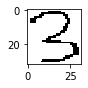

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 98.47 %


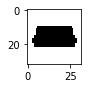

CNN/ANN Predictions:
Symbol_id: 66 , Latex: \eta , Confidence Score: 42.6 %
Symbol_id: 88 , Latex: \& , Confidence Score: 22.67 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.08 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 5.66 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 5.01 %
Symbol_id: 47 , Latex: k , Confidence Score: 4.08 %
Symbol_id: 17 , Latex: R , Confidence Score: 3.89 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.6 %
Symbol_id: 10 , Latex: K , Confidence Score: 1.47 %


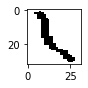

number of char in image: 8
Image path:  research/object_detection/training/test_images\exp0050.png


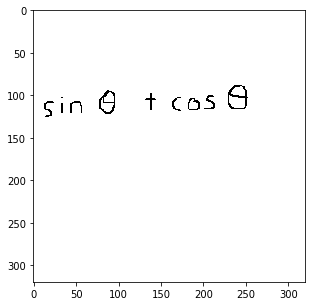

CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 65.74 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 10.2 %
Symbol_id: 49 , Latex: m , Confidence Score: 8.82 %
Symbol_id: 58 , Latex: w , Confidence Score: 6.91 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.53 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.28 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.05 %


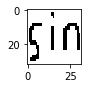

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 99.87 %


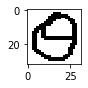

CNN/ANN Predictions:
Symbol_id: 97 , Latex: \forall , Confidence Score: 93.22 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.23 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.24 %


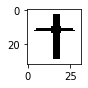

CNN/ANN Predictions:
Symbol_id: 74 , Latex: \omega , Confidence Score: 56.47 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 26.45 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 10.72 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.29 %


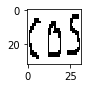

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 99.99 %


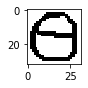

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0051.png


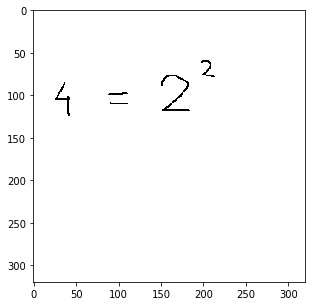

CNN/ANN Predictions:
Symbol_id: 30 , Latex: 4 , Confidence Score: 87.02 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 6.64 %
Symbol_id: 6 , Latex: G , Confidence Score: 2.32 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.15 %


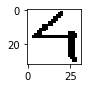

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 30.14 %
Symbol_id: 61 , Latex: z , Confidence Score: 24.83 %
Symbol_id: 94 , Latex: \div , Confidence Score: 7.69 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 6.96 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.84 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.14 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.46 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.06 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.57 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.52 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.45 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.27 %


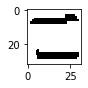

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 98.62 %


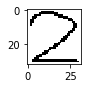

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 22.72 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 19.7 %
Symbol_id: 88 , Latex: \& , Confidence Score: 16.97 %
Symbol_id: 61 , Latex: z , Confidence Score: 16.88 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 12.91 %
Symbol_id: 25 , Latex: Z , Confidence Score: 5.31 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.17 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.09 %


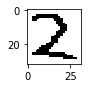

number of char in image: 4
Image path:  research/object_detection/training/test_images\exp0052.png


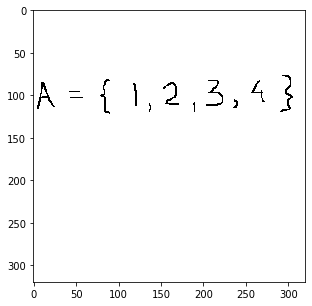

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 99.25 %


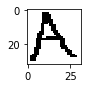

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 53.49 %
Symbol_id: 61 , Latex: z , Confidence Score: 14.92 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 13.34 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.25 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.82 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.1 %


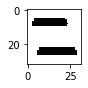

CNN/ANN Predictions:
Symbol_id: 86 , Latex: \{ , Confidence Score: 98.86 %


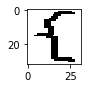

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 56.2 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 21.46 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 19.19 %


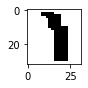

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 98.95 %


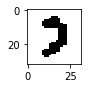

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 98.36 %


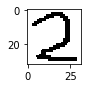

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 74.9 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 16.65 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.96 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.45 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.35 %


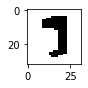

CNN/ANN Predictions:
Symbol_id: 29 , Latex: 3 , Confidence Score: 97.92 %


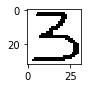

CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 98.59 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.36 %


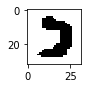

CNN/ANN Predictions:
Symbol_id: 30 , Latex: 4 , Confidence Score: 59.44 %
Symbol_id: 0 , Latex: A , Confidence Score: 22.92 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 4.09 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.12 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 2.74 %
Symbol_id: 53 , Latex: q , Confidence Score: 2.66 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.26 %


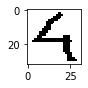

CNN/ANN Predictions:
Symbol_id: 29 , Latex: 3 , Confidence Score: 31.64 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 27.49 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 21.4 %
Symbol_id: 87 , Latex: \} , Confidence Score: 10.88 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.37 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.83 %


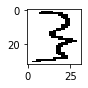

number of char in image: 11
Image path:  research/object_detection/training/test_images\exp0053.png


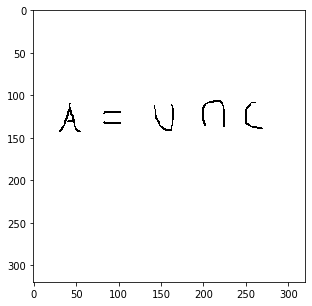

CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 69.81 %
Symbol_id: 0 , Latex: A , Confidence Score: 22.22 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 6.08 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.75 %


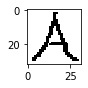

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 78.06 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.49 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 5.78 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.61 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.34 %


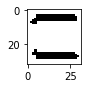

CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 85.56 %
Symbol_id: 56 , Latex: u , Confidence Score: 7.17 %
Symbol_id: 20 , Latex: U , Confidence Score: 2.16 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.42 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 1.3 %


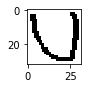

CNN/ANN Predictions:
Symbol_id: 95 , Latex: \cap , Confidence Score: 80.6 %
Symbol_id: 51 , Latex: o , Confidence Score: 9.49 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 4.4 %
Symbol_id: 50 , Latex: n , Confidence Score: 3.01 %


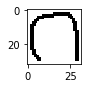

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 35.56 %
Symbol_id: 39 , Latex: c , Confidence Score: 25.24 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 15.85 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 6.21 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.59 %
Symbol_id: 99 , Latex: [ , Confidence Score: 4.46 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.8 %
Symbol_id: 2 , Latex: C , Confidence Score: 1.56 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.21 %


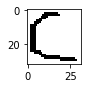

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0054.png


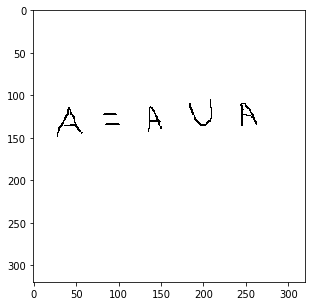

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 98.89 %


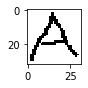

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 75.8 %
Symbol_id: 61 , Latex: z , Confidence Score: 7.42 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.15 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.73 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.32 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.12 %
Symbol_id: 8 , Latex: I , Confidence Score: 1.02 %


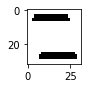

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 95.78 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.27 %


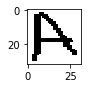

CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 94.22 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.37 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.28 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.08 %


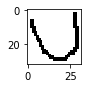

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 98.72 %


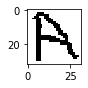

number of char in image: 5


In [75]:
for i in TEST_IMAGE_PATHS:
    image = cv2.imread(i)
    print('Image path: ', i)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY_INV) #threshold 
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)) 
    dilated = cv2.dilate(thresh,kernel,iterations = 5) 
    val,contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
    coord = []
    for contour in contours:  
        [x,y,w,h] = cv2.boundingRect(contour)   
        if h>300 and w>300:   
            continue   
        if h<7 or w<7:   
            continue  
        coord.append((x,y,w,h)) 
    coord.sort(key=lambda tup:tup[0]) # if the image has only one sentence sort in one axis
    count = 0
    for cor in coord:
        [x,y,w,h] = cor
        t = image[y:y+h,x:x+w,:]
        t = remove_wspaces(t)
        t = cv2.resize(t, (32,32))
        # convert to a binary array (contains either 1 or 0)
        _, t = cv2.threshold(t,150,255,cv2.THRESH_BINARY)
        
        # Predict label for cropped image with CNN
        t_im = np.asarray(t)
        t_im = cv2.cvtColor(t_im, cv2.COLOR_BGRA2RGBA)
        t_im = cv2.cvtColor(t_im, cv2.COLOR_RGBA2RGB)
        t_im = cv2.cvtColor(t_im, cv2.COLOR_RGB2GRAY)
        # t_im = cv2.resize(t_im, (32,32))
        t_im = t_im / 255.0
        
        # Symbol Prediction
        # CNN
        t_im = np.resize(t_im, (1, 1, 32, 32))
        res = cnn.predict(t_im)
        #
        # ANN
        #t_im = t_im.flatten().reshape((1, 32*32))
        #print(t_im.shape)
        #res = ann.predict(t_im)
        #
        res = res.flatten()
        # lbl = one_hot_encode_to_char(res, threshold=0.1)
        # if type(lbl) == list: lbl = lbl[0]
        # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
        lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
        print("CNN/ANN Predictions:")
        for j in lbls:
            symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
            latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
            print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')

        
        # Print figure
        plt.figure(figsize=(1,1))
        
        # plt.subplot(len(coord),1, count+1)
        plt.imshow(t)
        plt.show()
        count += 1
    print("number of char in image:", count)